In [1]:
import pandas as pd
import numpy as np

import torch.optim as opt
import torch.nn as nn

## Load the bert model, encoding function

In [2]:
from __future__ import absolute_import, division, unicode_literals
 
import sys
import io
import numpy as np
import logging
import argparse
import torch
import random
import tqdm
 
from transformers import *
import re

from sbert_wk_functions import create_embeddings
import encoders
import warnings
warnings.filterwarnings('ignore')

In [3]:
#model_name = "cambridgeltl/SapBERT-from-PubMedBERT-fulltext"
#model_name = "ttumyche/bluebert"
model_name  ='allenai/scibert_scivocab_uncased'
#model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
#model_name = "dmis-lab/biobert-large-cased-v1.1"
#model_name = "emilyalsentzer/Bio_ClinicalBERT"
#model_name = "GanjinZero/UMLSBert_ENG"
#model_name = "allenai/biomed_roberta_base"
config = AutoConfig.from_pretrained(model_name, cache_dir="./cache/" + re.split('/', model_name)[1])
config.output_hidden_states = True
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir="./cache/" + re.split('/', model_name)[1])
model = AutoModel.from_pretrained(
        model_name, config=config, cache_dir="./cache/"+re.split('/', model_name)[1]
    )

## load datasets

In [375]:
df = pd.read_csv("https://knights-lab.github.io/MLRepo/datasets/qin2012/taxatable.txt", sep = '\t')
#df = pd.read_csv("https://knights-lab.github.io/MLRepo/datasets/hmp/refseq/taxatable.txt", sep = '\t')


df['id'] = df[df.columns[0]].str.replace(r';*[a-z]_+', ' ').str.replace(r' +', ' ')

In [381]:
response = pd.read_csv("https://knights-lab.github.io/MLRepo/datasets/qin2012/task-healthy-diabetes.txt", sep = '\t')
#response = pd.read_csv("https://knights-lab.github.io/MLRepo/datasets/hmp/task-gastro-oral.txt", sep = '\t')
response

,#SampleID,Var
0,NLF008,N
1,DLM017,Y
2,DLM015,Y
3,DOF004,Y
4,DOF003,Y
...,...,...
119,NOF011,N
120,NOF007,N
121,NOF004,N
122,NLM009,N


In [377]:
df_counts = df.transpose()
df_counts.columns = df_counts.iloc[-1, ]
df_counts = df_counts.drop( [df.columns[0], 'id'], axis = 0)
df_counts = df_counts[list( df_counts.columns.dropna() )]

In [378]:
def fix_df(df):
    df_fixed = df.transpose()
    df_fixed.columns = df_fixed.iloc[-1, ]
    df_fixed = df_fixed.drop( [df.columns[0], 'id'], axis = 0)
    #df_fixed = df_fixed.loc[ df_fixed.sum(axis = 1)>500 , ] 
    df_fixed = df_fixed.div(df_fixed.sum(axis=1), axis=0)
    df_fixed = df_fixed[list( df_fixed.columns.dropna() )]
    return(df_fixed)

In [379]:
df_fixed = df.transpose()
df_fixed.columns = df_fixed.iloc[-1, ]
df_fixed = df_fixed.drop( [df.columns[0], 'id'], axis = 0)
#df_fixed = df_fixed.loc[ df_fixed.sum(axis = 1)>500 , ] 
df_fixed = df_fixed.div(df_fixed.sum(axis=1), axis=0)
df_fixed = df_fixed[list( df_fixed.columns.dropna() )]


df_merged_resp = df_fixed.merge(response, how = 'inner', left_index = True, right_on = '#SampleID')
df_merged_resp = df_merged_resp.drop([s for s in response.columns if s != 'Var'], axis = 1)

In [380]:
df_fixed

id,Bacteria Bacteroidetes Bacteroidia Bacteroidales Bacteroidaceae Bacteroides Bacteroide stercoris Bacteroide stercori ATCC_43183,Bacteria Bacteroidetes Bacteroidia Bacteroidales,Bacteria Actinobacteria Actinobacteria Bifidobacteriales Bifidobacteriaceae Bifidobacterium Bifidobacteriu adolescentis Bifidobacteriu adolescenti ATCC_15703,Archaea Euryarchaeota Methanobacteria Methanobacteriales Methanobacteriaceae Methanobrevibacter Methanobrevibacte smithii Methanobrevibacte smithi ATCC_35061,Archaea Euryarchaeota Methanobacteria Methanobacteriales Methanobacteriaceae,Archaea Euryarchaeota Methanobacteria Methanobacteriales Methanobacteriaceae Methanobrevibacter,Archaea Euryarchaeota Methanobacteria Methanobacteriales Methanobacteriaceae Methanobrevibacter Methanobrevibacte arboriphilus Methanobrevibacte arboriphilu ANOR1,Archaea Euryarchaeota Methanobacteria Methanobacteriales Methanobacteriaceae Methanobrevibacter Methanobrevibacte millerae,Bacteria,Archaea Euryarchaeota Methanobacteria Methanobacteriales Methanobacteriaceae Methanosphaera Methanosphaer stadtmanae Methanosphaer stadtmana DSM_3091,...,Viruses unclassifie bacteria viruses,Viruses unclassifie bacteria viruses Salmonell phag 64795_sal3,Viruses unclassifie bacteria viruses Salmonell phag 118970_sal3,Viruses unclassifie bacteria viruses Lactobacillu prophag Lj771,Viruses unclassifie bacteria viruses Streptococcu phag 20617,Viruses unclassifie bacteria viruses Staphylococcu phag phi2958PVL,Viruses unclassifie bacteria viruses Streptococcu phag phiARI0131-1,Viruses unclassifie bacteria viruses Streptococcu phag K13,Viruses unclassifie bacteria viruses Streptococcu phag IC1,Viruses unclassifie bacteria viruses Streptococcu phag phiARI0131-2
NLF008,0.0931647,0.050266,0,0,0,0,0,0,0.00177895,3.6257e-05,...,0,0,0,0,0,0,0,0,0,0
DLM017,0.0220546,0.0299474,1.12037e-05,0,0,0,0,0,0.000583929,0,...,0,0,0,0,0,0,0,0,0,0
DLM015,0.131476,0.0531973,4.60792e-07,1.84317e-06,0,0,0,0,0.000655937,1.84317e-06,...,0,0,4.60792e-07,0,0,0,0,0,0,0
DOF004,0.200285,0.0335881,6.66212e-05,0,0,0,0,0,0.000767765,0,...,0,0,0,0,0,0,0,0,0,0
DOF003,0.00264535,0.0464989,8.88597e-07,0,0,0,0,0,0.000682442,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NLM023,0.0030581,0.0152905,0,0,0,0,0,0,0.0030581,0,...,0,0,0,0,0,0,0,0,0,0
NLM016,0,0.25,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NOM012,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NOM013,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [404]:
names = pd.DataFrame( df_counts.columns.dropna() )
names['emb_idx'] = names.index
names.head()

,id,emb_idx
0,Bacteria Bacteroidetes Bacteroidia Bacteroida...,0
1,Bacteria Bacteroidetes Bacteroidia Bacteroidales,1
2,Bacteria Actinobacteria Actinobacteria Bifido...,2
3,Archaea Euryarchaeota Methanobacteria Methano...,3
4,Archaea Euryarchaeota Methanobacteria Methano...,4


In [9]:
def make_top_n_representation(row, names, model, tokenizer, n = 5):
    #resp = row.Var
    row = row.drop('Var')
    info = pd.DataFrame( row.astype(float) ).nlargest(n, row.name)\
                .reset_index().merge(names, left_on = 'index', right_on = 'id')
    return( torch.tensor( np.hstack((np.array( info[row.name] ).reshape(n, 1), 
                           create_embeddings(list(info.id), model, tokenizer) ))\
                        ) )

# def get_batch(ALL_REPS, batch_size = 5):
#     return(ALL_REPS[torch.randint(len(ALL_REPS), (batch_size,))])

In [10]:
%time
# ALL_REPS = torch.stack( [ make_top_n_representation(row, names, model, tokenizer, n = 5) \
#                              for _, row in df_fixed.iterrows() ] )
# ALL_REPS.shape

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [11]:
df_merged_resp = df_merged_resp.sample(frac = 1).reset_index(drop = True)
df_train, df_test = df_merged_resp.iloc[:int(.85 * df_merged_resp.shape[0] )], \
                    df_merged_resp.iloc[ int(.85 * df_merged_resp.shape[0] ):]

In [12]:
q = torch.zeros(5, 5, 40, 1)
q.shape

torch.Size([5, 5, 40, 1])

In [13]:
# class make_output(nn.Module):
#     def __init__(self, full_dim, hidden_dim, num_classes, num_taxons=5, dropout=0.1):
#         super().__init__()
        
#         self.dropout=nn.Dropout(dropout)
#         self.linear_hidden=nn.Linear(full_dim,1,bias=False)
#         self.relu = nn.ReLU()
#         self.linear_out=nn.Linear(num_taxons,num_classes,bias=True)
#         self.softmax=nn.Softmax(dim=-1)
#     def init_weights(self):
#         nn.init.xavier_uniform_(self.linear_out.weight)
 
#     def forward(self, x):
#         x = self.dropout(x)
#         x = self.relu(self.linear_hidden(x)).squeeze()
#         x = self.softmax(self.linear_out(x))
#         return(x)

class make_output(nn.Module):
    def __init__(self, hidden_dim, num_classes, dropout=0.1):
        super().__init__()        
        self.dropout=nn.Dropout(dropout)
        self.linear_out=nn.Linear(hidden_dim,num_classes,bias=False)
        self.softmax=nn.Softmax(dim=-1)
    def init_weights(self):
        nn.init.xavier_uniform_(self.linear_out.weight)
 
    def forward(self, x):
        x = self.dropout(x)
        #x = self.relu(self.linear_out(x)).squeeze()
        x = self.softmax(self.linear_out(x))
        return(x)
    
    
class linear_middle(nn.Module):
    def __init__(self, full_dim, hidden_dim, num_taxons=5, dropout = .1 ): 
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(full_dim, 1, bias = False)
        self.linear_2 = nn.Linear(num_taxons, hidden_dim, bias = True)
        self.relu = nn.ReLU()
        
    def init_weights(self):
        nn.init.xavier_uniform_(self.linear_1.weight)
        nn.init.xavier_uniform_(self.linear_2.weight)
        
    def forward(self, x):
        x = self.dropout(x)
        x = self.linear_1(x).squeeze()
        x = self.relu(x)
        x = self.linear_2(x)
        x = self.relu(x)
        return(x)

In [96]:
hidden_dim = 40
num_represented = 5
num_outputs = response.Var.nunique()

# SSA = encoders.StructuredSelfAttention(model_dim = config.hidden_size, 
#                                        hidden_dim = hidden_dim,
#                                        num_hops = 1)

SSA = linear_middle(full_dim = config.hidden_size, 
                    hidden_dim = hidden_dim)
SSA.init_weights()
#model_dim, hidden_dim, num_hops,dropout=0.1
mo = make_output(hidden_dim + 5, num_outputs)
#mo = make_output(5 + 5, num_outputs)

In [382]:
names

,id,emb_idx
0,Bacteria; Bacteroidetes; Bacteroidia; Bactero...,0
1,Bacteria; Actinobacteria; Coriobacteriia; Cor...,1
2,Bacteria; Actinobacteria; Actinobacteria; Bif...,2
3,Bacteria; Actinobacteria; Actinobacteria; Bif...,3
4,Bacteria; Actinobacteria; Actinobacteria; Act...,4
...,...,...
441,Bacteria; Tenericutes; Mollicutes; Mycoplasma...,441
442,Bacteria; Tenericutes; RF3; ML615J-28,442
443,Bacteria; Verrucomicrobia; Opitutae; Opitutal...,443
444,Bacteria; WPS-2,444


In [98]:
order = df_train.Var.value_counts()

def get_batch_df(df_train, n = 5):
    b = df_train#.sample(n=n)
    return(b.Var, torch.stack( [ make_top_n_representation(row, names, model, tokenizer, n = 5) \
                             for _, row in b.iterrows() ] ) )

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]



In [100]:
batch = get_batch_df(df_train.iloc[1:5, ])

batch_resp = batch[0]
batch_inp = batch[1]

numerical_resp = torch.tensor( pd.DataFrame(order).reset_index().reset_index().\
                    merge(pd.DataFrame( batch_resp ),left_on = 'index',right_on = 'Var').level_0 )

true_output = torch.tensor( to_categorical(numerical_resp, num_classes = order.shape[0]) )

In [101]:
true_output

tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1]], dtype=torch.uint8)

In [102]:
batch_inp[:, :, 0].float().unsqueeze(2).shape

torch.Size([4, 5, 1])

In [103]:
#example forward approach
#batch = get_batch_df(df_train)
out = SSA.forward(batch_inp[:, :, 1:].float() )
pred = mo(torch.cat((batch_inp[:, :, 0].float(), out), dim = 1))
pred

tensor([[0.4744, 0.5256],
        [0.4480, 0.5520],
        [0.4555, 0.5445],
        [0.4664, 0.5336]], grad_fn=<SoftmaxBackward>)

In [104]:
loss = loss_func(pred, true_output.float() )

In [116]:
opt_inner = opt.Adam([p for p in SSA.parameters()], lr = .1) # [p for p in model.parameters()] + 
opt_outer = opt.Adam([p for p in mo.parameters()], lr = .001)




In [117]:
loss.item()

0.46105071902275085

In [138]:
# names['id'] = names.id.str.split(' ').str[-4:].str.join(' ')
# df_train.columns = df_train.columns.str.split(' ').str[-4:].str.join(' ')
# df_test.columns = df_test.columns.str.split(' ').str[-4:].str.join(' ')


elements = {'model':model, #the bert model -- same across datasets
            'SSA':SSA, #my attention layer -- same across datasets
            'mo':mo, #the outer layer -- fitted separately for each dataset
            'opt_inner':opt_inner, #for bert_model and attention layer, preserved across datasets
            'opt_outer':opt_outer, #for outer layer, different for each dataset
            'names':names, 
            'a':pd.DataFrame(order).reset_index().reset_index(),
            'loss_func': nn.MSELoss()#nn.L1Loss()
               }

## organizing into a function

In [148]:
def run_training(df_train, 
                 elements,
                 loss_func = nn.L1Loss(), 
                 n_iters = None, 
                 batch_size = 5, 
                 num_taxons = 5):
    
    if n_iters == None:
        #on average, go through every point batch_size times
        n_iters = min( df_train.shape[0], 150 )
        
    TRAIN_LOSSES = np.zeros(n_iters)
    

        

    
    for _ in tqdm.tqdm(range(n_iters)):
        #select batch
        b = df_train.sample(n=batch_size)
        
        # run through bert model, applying it to the 5 most common taxonx
        batch_inp = torch.stack(\
            [ make_top_n_representation(row, 
                                         elements['names'], 
                                         elements['model'], 
                                         tokenizer, n = num_taxons) \
                     for ____, row in b.iterrows() ] )
        
#         if _ == 0:
#             print( b.Var )
#             for ____, row in b.iterrows():
#                 row__ = row.drop('Var')
#                 info = pd.DataFrame( row__.astype(float) ).nlargest(num_taxons, row__.name).reset_index()\
#                                     .merge(elements['names'], left_on = 'index', right_on = 'id')
#                 print(info.id)

#         #build inputs/output
        batch_resp = b.Var
        
        print(batch_resp)
        
        numerical_resp = torch.tensor( pd.DataFrame( batch_resp ).merge( elements['a'], how = 'left',
                                        left_on = 'Var',right_on = 'index').level_0 )

        true_output = torch.tensor( to_categorical(numerical_resp, num_classes = order.shape[0]) )
        
        #print(batch_inp[:, :, 1:10].float() )
    
        out = elements['SSA'].forward(batch_inp[:, :, 1:].float() )
        pred = elements['mo'](torch.cat((batch_inp[:, :, 0].float(), out), dim = 1))
        
        #get loss
        print(pred)
        print(true_output)
        loss = elements['loss_func'](pred[:, 1], numerical_resp.float() )#true_output.float() )
        
        
        #store batch loss
        TRAIN_LOSSES[_] = loss.item()
        
        #do gradient steps
        elements['opt_inner'].zero_grad()
        elements['opt_outer'].zero_grad()

        loss.backward()
        
        elements['opt_inner'].step()
        elements['opt_outer'].step()
        
        if _%5 == 0 and _>0:
            print('Train Loss over last 5 batches: {}'.format( \
                                                    TRAIN_LOSSES[(_-5):_].mean() \
                                                             ))
    
    elements['train_loss'] = TRAIN_LOSSES
    
    #don't really need to return elements, since we're adjusting the old object
    #just for the sake of returning something....
    return(elements)
        

In [149]:
elements = run_training(df_train, elements, n_iters = 10000)
#torch.save(elements, 'elements.pt')

  0%|          | 1/10000 [00:02<6:30:23,  2.34s/it]

46    Y
66    N
12    Y
34    N
22    N
Name: Var, dtype: object
tensor([[0.6475, 0.3525],
        [0.9615, 0.0385],
        [0.9617, 0.0383],
        [0.7994, 0.2006],
        [0.9567, 0.0433]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  0%|          | 2/10000 [00:04<6:26:15,  2.32s/it]

38     N
77     Y
31     N
101    Y
102    N
Name: Var, dtype: object
tensor([[0.3828, 0.6172],
        [0.3802, 0.6198],
        [0.0481, 0.9519],
        [0.2483, 0.7517],
        [0.2150, 0.7850]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  0%|          | 3/10000 [00:07<6:34:51,  2.37s/it]

92    N
4     N
51    N
1     N
57    N
Name: Var, dtype: object
tensor([[0.6886, 0.3114],
        [0.0453, 0.9547],
        [0.1637, 0.8363],
        [0.6516, 0.3484],
        [0.5337, 0.4663]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  0%|          | 4/10000 [00:09<6:57:05,  2.50s/it]

42     Y
80     N
26     N
62     Y
102    N
Name: Var, dtype: object
tensor([[0.7319, 0.2681],
        [0.8005, 0.1995],
        [0.9022, 0.0978],
        [0.2770, 0.7230],
        [0.8032, 0.1968]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  0%|          | 5/10000 [00:12<7:07:38,  2.57s/it]

23    Y
60    Y
99    Y
34    N
85    Y
Name: Var, dtype: object
tensor([[0.7132, 0.2868],
        [0.8516, 0.1484],
        [0.8918, 0.1082],
        [0.0438, 0.9562],
        [0.9710, 0.0290]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  0%|          | 6/10000 [00:15<6:58:35,  2.51s/it]

93     N
20     N
62     Y
43     Y
101    Y
Name: Var, dtype: object
tensor([[0.5104, 0.4896],
        [0.6840, 0.3160],
        [0.5679, 0.4321],
        [0.2962, 0.7038],
        [0.4075, 0.5925]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.31098225004971025


  0%|          | 7/10000 [00:17<7:13:50,  2.60s/it]

87     Y
23     Y
33     Y
35     N
104    Y
Name: Var, dtype: object
tensor([[0.7841, 0.2159],
        [0.8192, 0.1808],
        [0.9239, 0.0761],
        [0.8956, 0.1044],
        [0.1432, 0.8568]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  0%|          | 8/10000 [00:20<7:19:39,  2.64s/it]

10    N
21    N
98    Y
45    N
15    Y
Name: Var, dtype: object
tensor([[0.8824, 0.1176],
        [0.0078, 0.9922],
        [0.3871, 0.6129],
        [0.8374, 0.1626],
        [0.1593, 0.8407]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  0%|          | 9/10000 [00:23<7:53:48,  2.85s/it]

37     N
14     Y
53     Y
12     Y
102    N
Name: Var, dtype: object
tensor([[0.3584, 0.6416],
        [0.4960, 0.5040],
        [0.4213, 0.5787],
        [0.7295, 0.2705],
        [0.5547, 0.4453]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  0%|          | 10/10000 [00:26<7:31:59,  2.71s/it]

72    N
31    N
30    Y
98    Y
79    N
Name: Var, dtype: object
tensor([[0.4786, 0.5214],
        [0.0486, 0.9514],
        [0.6891, 0.3109],
        [0.3877, 0.6123],
        [0.8225, 0.1775]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  0%|          | 11/10000 [00:28<7:08:43,  2.58s/it]

2     N
3     N
94    N
81    Y
25    Y
Name: Var, dtype: object
tensor([[0.0036, 0.9964],
        [0.0803, 0.9197],
        [0.9326, 0.0674],
        [0.1426, 0.8574],
        [0.9496, 0.0504]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.336906424164772


  0%|          | 12/10000 [00:31<7:04:22,  2.55s/it]

54    N
81    Y
39    N
11    Y
90    N
Name: Var, dtype: object
tensor([[0.4127, 0.5873],
        [0.8885, 0.1115],
        [0.9508, 0.0492],
        [0.7323, 0.2677],
        [0.9892, 0.0108]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  0%|          | 13/10000 [00:33<6:54:58,  2.49s/it]

98    Y
89    Y
70    N
28    Y
84    N
Name: Var, dtype: object
tensor([[0.3885, 0.6115],
        [0.6650, 0.3350],
        [0.1286, 0.8714],
        [0.9053, 0.0947],
        [0.6640, 0.3360]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  0%|          | 14/10000 [00:35<6:46:07,  2.44s/it]

83     Y
88     Y
59     N
104    Y
7      Y
Name: Var, dtype: object
tensor([[0.3685, 0.6315],
        [0.1486, 0.8514],
        [0.9472, 0.0528],
        [0.1443, 0.8557],
        [0.6829, 0.3171]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  0%|          | 15/10000 [00:37<6:38:17,  2.39s/it]

21    N
29    N
55    Y
70    N
47    N
Name: Var, dtype: object
tensor([[0.0079, 0.9921],
        [0.1916, 0.8084],
        [0.5714, 0.4286],
        [0.8140, 0.1860],
        [0.6600, 0.3400]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  0%|          | 16/10000 [00:40<6:54:26,  2.49s/it]

81    Y
48    N
79    N
36    Y
56    Y
Name: Var, dtype: object
tensor([[0.8886, 0.1114],
        [0.9260, 0.0740],
        [0.8231, 0.1769],
        [0.2410, 0.7590],
        [0.9222, 0.0778]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.35503069758415223


  0%|          | 17/10000 [00:43<6:48:23,  2.45s/it]

73    Y
62    Y
99    Y
21    N
7     Y
Name: Var, dtype: object
tensor([[0.6361, 0.3639],
        [0.5705, 0.4295],
        [0.8112, 0.1888],
        [0.0063, 0.9937],
        [0.6837, 0.3163]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  0%|          | 18/10000 [00:46<7:13:09,  2.60s/it]

57    N
77    Y
88    Y
81    Y
96    N
Name: Var, dtype: object
tensor([[0.5377, 0.4623],
        [0.0872, 0.9128],
        [0.1494, 0.8506],
        [0.0838, 0.9162],
        [0.8782, 0.1218]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  0%|          | 19/10000 [00:48<7:21:26,  2.65s/it]

64    Y
10    N
36    Y
43    Y
20    N
Name: Var, dtype: object
tensor([[0.8913, 0.1087],
        [0.9585, 0.0415],
        [0.1468, 0.8532],
        [0.2990, 0.7010],
        [0.9119, 0.0881]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  0%|          | 20/10000 [00:51<7:11:41,  2.60s/it]

39    N
66    N
52    Y
11    Y
48    N
Name: Var, dtype: object
tensor([[0.7568, 0.2432],
        [0.7873, 0.2127],
        [0.7134, 0.2866],
        [0.4729, 0.5271],
        [0.2545, 0.7455]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  0%|          | 21/10000 [00:54<7:19:18,  2.64s/it]

22    N
95    Y
79    N
11    Y
53    Y
Name: Var, dtype: object
tensor([[0.8234, 0.1766],
        [0.7914, 0.2086],
        [0.5715, 0.4285],
        [0.2614, 0.7386],
        [0.8324, 0.1676]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.4254858374595642


  0%|          | 22/10000 [00:56<7:04:13,  2.55s/it]

102    N
69     N
23     Y
59     N
38     N
Name: Var, dtype: object
tensor([[0.9128, 0.0872],
        [0.3842, 0.6158],
        [0.4605, 0.5395],
        [0.9477, 0.0523],
        [0.3888, 0.6112]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  0%|          | 23/10000 [00:58<6:57:06,  2.51s/it]

31    N
82    Y
36    Y
61    N
40    Y
Name: Var, dtype: object
tensor([[0.0273, 0.9727],
        [0.8568, 0.1432],
        [0.2431, 0.7569],
        [0.5865, 0.4135],
        [0.8527, 0.1473]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  0%|          | 24/10000 [01:01<6:51:50,  2.48s/it]

27    N
31    N
68    N
6     N
0     N
Name: Var, dtype: object
tensor([[0.1985, 0.8015],
        [0.3102, 0.6898],
        [0.0154, 0.9846],
        [0.3754, 0.6246],
        [0.0898, 0.9102]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  0%|          | 25/10000 [01:03<6:57:45,  2.51s/it]

15    Y
59    N
81    Y
7     Y
6     N
Name: Var, dtype: object
tensor([[0.1633, 0.8367],
        [0.7411, 0.2589],
        [0.1455, 0.8545],
        [0.6855, 0.3145],
        [0.3755, 0.6245]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  0%|          | 26/10000 [01:06<7:01:30,  2.54s/it]

101    Y
61     N
10     N
40     Y
36     Y
Name: Var, dtype: object
tensor([[0.8705, 0.1295],
        [0.2835, 0.7165],
        [0.2416, 0.7584],
        [0.3560, 0.6440],
        [0.1383, 0.8617]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.29627713859081267


  0%|          | 27/10000 [01:08<6:55:17,  2.50s/it]

48    N
84    N
3     N
92    N
61    N
Name: Var, dtype: object
tensor([[0.0975, 0.9025],
        [0.8447, 0.1553],
        [0.0437, 0.9563],
        [0.6918, 0.3082],
        [0.5871, 0.4129]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  0%|          | 28/10000 [01:11<6:48:12,  2.46s/it]

86    Y
47    N
49    N
31    N
7     Y
Name: Var, dtype: object
tensor([[0.9049, 0.0951],
        [0.4097, 0.5903],
        [0.7664, 0.2336],
        [0.0297, 0.9703],
        [0.6858, 0.3142]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  0%|          | 29/10000 [01:13<6:46:03,  2.44s/it]

69    N
49    N
12    Y
26    N
76    Y
Name: Var, dtype: object
tensor([[0.6340, 0.3660],
        [0.7664, 0.2336],
        [0.7534, 0.2466],
        [0.8189, 0.1811],
        [0.8043, 0.1957]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  0%|          | 30/10000 [01:16<7:08:11,  2.58s/it]

84    N
51    N
17    Y
13    Y
75    N
Name: Var, dtype: object
tensor([[0.6669, 0.3331],
        [0.0593, 0.9407],
        [0.7120, 0.2880],
        [0.9082, 0.0918],
        [0.1375, 0.8625]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  0%|          | 31/10000 [01:19<7:18:36,  2.64s/it]

25    Y
47    N
40    Y
43    Y
85    Y
Name: Var, dtype: object
tensor([[0.9500, 0.0500],
        [0.6624, 0.3376],
        [0.8527, 0.1473],
        [0.3004, 0.6996],
        [0.6474, 0.3526]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.24169861674308776


  0%|          | 32/10000 [01:21<7:14:52,  2.62s/it]

5      Y
100    N
44     Y
8      Y
14     Y
Name: Var, dtype: object
tensor([[0.5911, 0.4089],
        [0.6650, 0.3350],
        [0.8841, 0.1159],
        [0.9530, 0.0470],
        [0.8395, 0.1605]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  0%|          | 33/10000 [01:24<7:04:43,  2.56s/it]

27    N
76    Y
31    N
53    Y
78    N
Name: Var, dtype: object
tensor([[0.1986, 0.8014],
        [0.3077, 0.6923],
        [0.0273, 0.9727],
        [0.7418, 0.2582],
        [0.8720, 0.1280]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  0%|          | 34/10000 [01:26<7:04:48,  2.56s/it]

79     N
9      Y
100    N
28     Y
49     N
Name: Var, dtype: object
tensor([[0.5600, 0.4400],
        [0.9679, 0.0321],
        [0.8115, 0.1885],
        [0.9061, 0.0939],
        [0.7658, 0.2342]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  0%|          | 35/10000 [01:29<7:10:57,  2.59s/it]

87    Y
93    N
77    Y
69    N
39    N
Name: Var, dtype: object
tensor([[0.1453, 0.8547],
        [0.3433, 0.6567],
        [0.0495, 0.9505],
        [0.6330, 0.3670],
        [0.8400, 0.1600]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  0%|          | 36/10000 [01:31<6:57:47,  2.52s/it]

32     Y
60     Y
38     N
42     Y
100    N
Name: Var, dtype: object
tensor([[0.5678, 0.4322],
        [0.8535, 0.1465],
        [0.0931, 0.9069],
        [0.5465, 0.4535],
        [0.0118, 0.9882]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.30001973211765287


  0%|          | 37/10000 [01:34<7:03:10,  2.55s/it]

99    Y
87    Y
94    N
14    Y
91    Y
Name: Var, dtype: object
tensor([[0.8117, 0.1883],
        [0.7871, 0.2129],
        [0.9330, 0.0670],
        [0.8392, 0.1608],
        [0.8557, 0.1443]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  0%|          | 38/10000 [01:37<7:41:31,  2.78s/it]

50    Y
24    Y
94    N
67    N
46    Y
Name: Var, dtype: object
tensor([[0.4518, 0.5482],
        [0.3090, 0.6910],
        [0.9330, 0.0670],
        [0.8234, 0.1766],
        [0.9329, 0.0671]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  0%|          | 39/10000 [01:40<7:55:56,  2.87s/it]

78    N
14    Y
25    Y
35    N
90    N
Name: Var, dtype: object
tensor([[0.0391, 0.9609],
        [0.8391, 0.1609],
        [0.9498, 0.0502],
        [0.8967, 0.1033],
        [0.9205, 0.0795]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  0%|          | 40/10000 [01:43<7:31:43,  2.72s/it]

14    Y
71    Y
89    Y
36    Y
72    N
Name: Var, dtype: object
tensor([[0.8391, 0.1609],
        [0.1176, 0.8824],
        [0.6662, 0.3338],
        [0.4260, 0.5740],
        [0.6390, 0.3610]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  0%|          | 41/10000 [01:45<7:12:42,  2.61s/it]

81    Y
56    Y
82    Y
35    N
37    N
Name: Var, dtype: object
tensor([[0.0847, 0.9153],
        [0.6905, 0.3095],
        [0.7657, 0.2343],
        [0.8966, 0.1034],
        [0.5499, 0.4501]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.28345295041799545


  0%|          | 42/10000 [01:47<6:57:23,  2.51s/it]

83    Y
71    Y
14    Y
54    N
58    Y
Name: Var, dtype: object
tensor([[0.5977, 0.4023],
        [0.5133, 0.4867],
        [0.8391, 0.1609],
        [0.9225, 0.0775],
        [0.8762, 0.1238]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  0%|          | 43/10000 [01:50<6:55:19,  2.50s/it]

77    Y
2     N
47    N
43    Y
62    Y
Name: Var, dtype: object
tensor([[0.5934, 0.4066],
        [0.0037, 0.9963],
        [0.2908, 0.7092],
        [0.1802, 0.8198],
        [0.3531, 0.6469]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  0%|          | 44/10000 [01:52<7:06:05,  2.57s/it]

44    Y
55    Y
92    N
78    N
45    N
Name: Var, dtype: object
tensor([[0.8838, 0.1162],
        [0.5739, 0.4261],
        [0.4885, 0.5115],
        [0.0392, 0.9608],
        [0.1189, 0.8811]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  0%|          | 45/10000 [01:55<7:19:39,  2.65s/it]

11    Y
43    Y
32    Y
3     N
29    N
Name: Var, dtype: object
tensor([[0.6884, 0.3116],
        [0.3002, 0.6998],
        [0.1745, 0.8255],
        [0.1839, 0.8161],
        [0.4756, 0.5244]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  0%|          | 46/10000 [01:58<7:27:18,  2.70s/it]

51    N
85    Y
27    N
13    Y
15    Y
Name: Var, dtype: object
tensor([[0.1687, 0.8313],
        [0.6241, 0.3759],
        [0.1988, 0.8012],
        [0.7676, 0.2324],
        [0.1634, 0.8366]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.26816147565841675


  0%|          | 47/10000 [02:01<7:21:07,  2.66s/it]

37    N
68    N
15    Y
22    N
48    N
Name: Var, dtype: object
tensor([[0.9092, 0.0908],
        [0.0155, 0.9845],
        [0.1636, 0.8364],
        [0.9574, 0.0426],
        [0.2561, 0.7439]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  0%|          | 48/10000 [02:03<7:06:45,  2.57s/it]

33     Y
31     N
26     N
68     N
100    N
Name: Var, dtype: object
tensor([[0.9248, 0.0752],
        [0.0498, 0.9502],
        [0.9618, 0.0382],
        [0.0156, 0.9844],
        [0.0182, 0.9818]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  0%|          | 49/10000 [02:06<7:03:55,  2.56s/it]

34    N
91    Y
18    Y
75    N
10    N
Name: Var, dtype: object
tensor([[0.0481, 0.9519],
        [0.5458, 0.4542],
        [0.9145, 0.0855],
        [0.1378, 0.8622],
        [0.2423, 0.7577]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  0%|          | 50/10000 [02:08<6:55:01,  2.50s/it]

15    Y
72    N
25    Y
8     Y
56    Y
Name: Var, dtype: object
tensor([[0.1641, 0.8359],
        [0.6401, 0.3599],
        [0.9499, 0.0501],
        [0.4006, 0.5994],
        [0.6912, 0.3088]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|          | 51/10000 [02:11<7:00:30,  2.54s/it]

32     Y
26     N
48     N
79     N
101    Y
Name: Var, dtype: object
tensor([[0.0503, 0.9497],
        [0.8190, 0.1810],
        [0.2571, 0.7429],
        [0.8242, 0.1758],
        [0.4393, 0.5607]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.25059773251414297


  1%|          | 52/10000 [02:13<7:01:36,  2.54s/it]

37    N
45    N
72    N
54    N
86    Y
Name: Var, dtype: object
tensor([[0.6413, 0.3587],
        [0.0617, 0.9383],
        [0.8143, 0.1857],
        [0.4178, 0.5822],
        [0.9048, 0.0952]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  1%|          | 53/10000 [02:16<6:56:07,  2.51s/it]

32    Y
28    Y
27    N
45    N
58    Y
Name: Var, dtype: object
tensor([[0.1758, 0.8242],
        [0.1840, 0.8160],
        [0.2001, 0.7999],
        [0.0564, 0.9436],
        [0.2787, 0.7213]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  1%|          | 54/10000 [02:18<6:59:42,  2.53s/it]

37    N
22    N
11    Y
66    N
4     N
Name: Var, dtype: object
tensor([[0.6414, 0.3586],
        [0.9576, 0.0424],
        [0.4749, 0.5251],
        [0.7864, 0.2136],
        [0.0471, 0.9529]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  1%|          | 55/10000 [02:21<6:59:43,  2.53s/it]

94    N
27    N
78    N
98    Y
49    N
Name: Var, dtype: object
tensor([[0.9333, 0.0667],
        [0.2003, 0.7997],
        [0.0397, 0.9603],
        [0.1646, 0.8354],
        [0.7669, 0.2331]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  1%|          | 56/10000 [02:23<6:47:25,  2.46s/it]

78    N
55    Y
67    N
5     Y
39    N
Name: Var, dtype: object
tensor([[0.0398, 0.9602],
        [0.2893, 0.7107],
        [0.4193, 0.5807],
        [0.5926, 0.4074],
        [0.7580, 0.2420]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.40905572175979615


  1%|          | 57/10000 [02:26<6:53:05,  2.49s/it]

47    N
80    N
15    Y
30    Y
70    N
Name: Var, dtype: object
tensor([[0.6636, 0.3364],
        [0.8934, 0.1066],
        [0.1649, 0.8351],
        [0.0849, 0.9151],
        [0.1309, 0.8691]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  1%|          | 58/10000 [02:29<7:23:51,  2.68s/it]

31     N
103    Y
60     Y
15     Y
46     Y
Name: Var, dtype: object
tensor([[0.3107, 0.6893],
        [0.8659, 0.1341],
        [0.5679, 0.4321],
        [0.1650, 0.8350],
        [0.6546, 0.3454]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|          | 59/10000 [02:31<7:15:16,  2.63s/it]

82    Y
85    Y
1     N
64    Y
46    Y
Name: Var, dtype: object
tensor([[0.8574, 0.1426],
        [0.8903, 0.1097],
        [0.6577, 0.3423],
        [0.9250, 0.0750],
        [0.3288, 0.6712]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|          | 60/10000 [02:34<7:02:08,  2.55s/it]

98    Y
69    N
92    N
99    Y
44    Y
Name: Var, dtype: object
tensor([[0.8675, 0.1325],
        [0.6357, 0.3643],
        [0.6924, 0.3076],
        [0.8128, 0.1872],
        [0.8845, 0.1155]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|          | 61/10000 [02:36<6:52:09,  2.49s/it]

81    Y
54    N
43    Y
40    Y
35    N
Name: Var, dtype: object
tensor([[0.0862, 0.9138],
        [0.4187, 0.5813],
        [0.8431, 0.1569],
        [0.9130, 0.0870],
        [0.8974, 0.1026]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.2880668371915817


  1%|          | 62/10000 [02:38<6:41:23,  2.42s/it]

32    Y
70    N
48    N
83    Y
67    N
Name: Var, dtype: object
tensor([[0.1165, 0.8835],
        [0.8879, 0.1121],
        [0.2583, 0.7417],
        [0.7780, 0.2220],
        [0.7950, 0.2050]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  1%|          | 63/10000 [02:41<6:43:57,  2.44s/it]

59    N
23    Y
95    Y
8     Y
85    Y
Name: Var, dtype: object
tensor([[0.9478, 0.0522],
        [0.7177, 0.2823],
        [0.3144, 0.6856],
        [0.7052, 0.2948],
        [0.6482, 0.3518]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|          | 64/10000 [02:43<6:37:13,  2.40s/it]

48    N
12    Y
54    N
94    N
3     N
Name: Var, dtype: object
tensor([[0.2585, 0.7415],
        [0.7539, 0.2461],
        [0.4189, 0.5811],
        [0.9333, 0.0667],
        [0.0832, 0.9168]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  1%|          | 65/10000 [02:45<6:36:06,  2.39s/it]

49    N
62    Y
57    N
74    N
21    N
Name: Var, dtype: object
tensor([[0.7673, 0.2327],
        [0.3259, 0.6741],
        [0.5420, 0.4580],
        [0.7604, 0.2396],
        [0.0083, 0.9917]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  1%|          | 66/10000 [02:48<6:31:35,  2.37s/it]

99     Y
58     Y
101    Y
12     Y
81     Y
Name: Var, dtype: object
tensor([[0.6014, 0.3986],
        [0.7847, 0.2153],
        [0.2543, 0.7457],
        [0.9246, 0.0754],
        [0.0239, 0.9761]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.35677489042282107


  1%|          | 67/10000 [02:50<6:29:22,  2.35s/it]

33     Y
2      N
102    N
70     N
32     Y
Name: Var, dtype: object
tensor([[0.9251, 0.0749],
        [0.0038, 0.9962],
        [0.9126, 0.0874],
        [0.5116, 0.4884],
        [0.0507, 0.9493]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  1%|          | 68/10000 [02:52<6:31:25,  2.36s/it]

53    Y
18    Y
34    N
97    Y
73    Y
Name: Var, dtype: object
tensor([[0.5868, 0.4132],
        [0.9147, 0.0853],
        [0.8839, 0.1161],
        [0.8911, 0.1089],
        [0.8728, 0.1272]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|          | 69/10000 [02:55<6:34:00,  2.38s/it]

60    Y
66    N
74    N
62    Y
95    Y
Name: Var, dtype: object
tensor([[0.8545, 0.1455],
        [0.9792, 0.0208],
        [0.7603, 0.2397],
        [0.5744, 0.4256],
        [0.9019, 0.0981]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|          | 70/10000 [02:57<6:33:01,  2.37s/it]

42     Y
12     Y
103    Y
33     Y
102    N
Name: Var, dtype: object
tensor([[0.5495, 0.4505],
        [0.9246, 0.0754],
        [0.4809, 0.5191],
        [0.9251, 0.0749],
        [0.5608, 0.4392]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  1%|          | 71/10000 [03:00<6:52:18,  2.49s/it]

5     Y
70    N
41    Y
80    N
42    Y
Name: Var, dtype: object
tensor([[0.5932, 0.4068],
        [0.2514, 0.7486],
        [0.2000, 0.8000],
        [0.8036, 0.1964],
        [0.2052, 0.7948]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.29021751284599306


  1%|          | 72/10000 [03:03<7:30:18,  2.72s/it]

45    N
78    N
3     N
15    Y
97    Y
Name: Var, dtype: object
tensor([[0.1207, 0.8793],
        [0.0401, 0.9599],
        [0.0833, 0.9167],
        [0.1658, 0.8342],
        [0.8912, 0.1088]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|          | 73/10000 [03:06<7:14:13,  2.62s/it]

81     Y
12     Y
53     Y
100    N
6      N
Name: Var, dtype: object
tensor([[0.1481, 0.8519],
        [0.9247, 0.0753],
        [0.7432, 0.2568],
        [0.0186, 0.9814],
        [0.3780, 0.6220]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  1%|          | 74/10000 [03:08<7:05:01,  2.57s/it]

9     Y
26    N
60    Y
82    Y
38    N
Name: Var, dtype: object
tensor([[0.9680, 0.0320],
        [0.4922, 0.5078],
        [0.8547, 0.1453],
        [0.8577, 0.1423],
        [0.3927, 0.6073]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  1%|          | 75/10000 [03:10<7:02:57,  2.56s/it]

46    Y
24    Y
92    N
91    Y
93    N
Name: Var, dtype: object
tensor([[0.6256, 0.3744],
        [0.0636, 0.9364],
        [0.6928, 0.3072],
        [0.5473, 0.4527],
        [0.9472, 0.0528]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  1%|          | 76/10000 [03:13<6:59:28,  2.54s/it]

43    Y
55    Y
82    Y
49    N
59    N
Name: Var, dtype: object
tensor([[0.6920, 0.3080],
        [0.7580, 0.2420],
        [0.8578, 0.1422],
        [0.4136, 0.5864],
        [0.9478, 0.0522]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.2742284178733826


  1%|          | 77/10000 [03:15<6:48:01,  2.47s/it]

94    N
58    Y
2     N
54    N
24    Y
Name: Var, dtype: object
tensor([[0.9334, 0.0666],
        [0.3243, 0.6757],
        [0.0038, 0.9962],
        [0.4199, 0.5801],
        [0.2035, 0.7965]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  1%|          | 78/10000 [03:18<6:44:04,  2.44s/it]

25    Y
24    Y
54    N
35    N
47    N
Name: Var, dtype: object
tensor([[0.9500, 0.0500],
        [0.2036, 0.7964],
        [0.4200, 0.5800],
        [0.9516, 0.0484],
        [0.3785, 0.6215]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  1%|          | 79/10000 [03:20<6:47:36,  2.47s/it]

49    N
60    Y
23    Y
43    Y
77    Y
Name: Var, dtype: object
tensor([[0.7680, 0.2320],
        [0.8549, 0.1451],
        [0.7184, 0.2816],
        [0.8431, 0.1569],
        [0.0103, 0.9897]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|          | 80/10000 [03:23<6:43:28,  2.44s/it]

8     Y
1     N
37    N
32    Y
3     N
Name: Var, dtype: object
tensor([[0.7062, 0.2938],
        [0.6590, 0.3410],
        [0.6429, 0.3571],
        [0.1777, 0.8223],
        [0.1870, 0.8130]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  1%|          | 81/10000 [03:25<6:49:29,  2.48s/it]

91    Y
28    Y
31    N
17    Y
8     Y
Name: Var, dtype: object
tensor([[0.5477, 0.4523],
        [0.9068, 0.0932],
        [0.0261, 0.9739],
        [0.6742, 0.3258],
        [0.7062, 0.2938]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.34332377910614015


  1%|          | 82/10000 [03:28<7:22:08,  2.67s/it]

74    N
25    Y
10    N
65    Y
36    Y
Name: Var, dtype: object
tensor([[0.7611, 0.2389],
        [0.9501, 0.0499],
        [0.0903, 0.9097],
        [0.6893, 0.3107],
        [0.0576, 0.9424]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|          | 83/10000 [03:31<7:23:55,  2.69s/it]

38    N
48    N
29    N
66    N
0     N
Name: Var, dtype: object
tensor([[0.1608, 0.8392],
        [0.2602, 0.7398],
        [0.4795, 0.5205],
        [0.9620, 0.0380],
        [0.1643, 0.8357]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  1%|          | 84/10000 [03:34<7:16:47,  2.64s/it]

103    Y
66     N
13     Y
24     Y
58     Y
Name: Var, dtype: object
tensor([[0.8665, 0.1335],
        [0.7869, 0.2131],
        [0.2603, 0.7397],
        [0.2040, 0.7960],
        [0.5598, 0.4402]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|          | 85/10000 [03:36<7:08:47,  2.59s/it]

34    N
85    Y
0     N
79    N
47    N
Name: Var, dtype: object
tensor([[0.2061, 0.7939],
        [0.7087, 0.2913],
        [0.4086, 0.5914],
        [0.8249, 0.1751],
        [0.6653, 0.3347]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  1%|          | 86/10000 [03:38<6:57:41,  2.53s/it]

4     N
91    Y
85    Y
39    N
9     Y
Name: Var, dtype: object
tensor([[0.0478, 0.9522],
        [0.5478, 0.4522],
        [0.8906, 0.1094],
        [0.4783, 0.5217],
        [0.9680, 0.0320]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.26743203550577166


  1%|          | 87/10000 [03:41<6:59:25,  2.54s/it]

69    N
47    N
78    N
88    Y
18    Y
Name: Var, dtype: object
tensor([[0.6376, 0.3624],
        [0.6652, 0.3348],
        [0.0167, 0.9833],
        [0.2647, 0.7353],
        [0.9150, 0.0850]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|          | 88/10000 [03:43<6:48:21,  2.47s/it]

54     N
45     N
12     Y
82     Y
100    N
Name: Var, dtype: object
tensor([[0.9224, 0.0776],
        [0.1215, 0.8785],
        [0.9248, 0.0752],
        [0.8580, 0.1420],
        [0.0088, 0.9912]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  1%|          | 89/10000 [03:47<7:47:16,  2.83s/it]

59     N
64     Y
71     Y
101    Y
73     Y
Name: Var, dtype: object
tensor([[0.6656, 0.3344],
        [0.9250, 0.0750],
        [0.5187, 0.4813],
        [0.6208, 0.3792],
        [0.8730, 0.1270]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|          | 90/10000 [03:50<8:17:47,  3.01s/it]

35    N
55    Y
86    Y
7     Y
76    Y
Name: Var, dtype: object
tensor([[0.8976, 0.1024],
        [0.8407, 0.1593],
        [0.8405, 0.1595],
        [0.6877, 0.3123],
        [0.8049, 0.1951]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|          | 91/10000 [03:55<9:16:09,  3.37s/it]

62    Y
34    N
79    N
49    N
27    N
Name: Var, dtype: object
tensor([[0.4192, 0.5808],
        [0.0577, 0.9423],
        [0.8247, 0.1753],
        [0.6113, 0.3887],
        [0.2024, 0.7976]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.1827761560678482


  1%|          | 92/10000 [03:57<8:52:09,  3.22s/it]

61    N
93    N
26    N
11    Y
66    N
Name: Var, dtype: object
tensor([[0.5898, 0.4102],
        [0.6032, 0.3968],
        [0.6910, 0.3090],
        [0.4766, 0.5234],
        [0.8733, 0.1267]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  1%|          | 93/10000 [04:00<8:19:57,  3.03s/it]

63    N
45    N
32    Y
51    N
42    Y
Name: Var, dtype: object
tensor([[0.5509, 0.4491],
        [0.0572, 0.9428],
        [0.1777, 0.8223],
        [0.1723, 0.8277],
        [0.5506, 0.4494]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  1%|          | 94/10000 [04:02<7:48:10,  2.84s/it]

29    N
85    Y
22    N
24    Y
0     N
Name: Var, dtype: object
tensor([[0.4790, 0.5210],
        [0.9710, 0.0290],
        [0.7311, 0.2689],
        [0.2037, 0.7963],
        [0.1640, 0.8360]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  1%|          | 95/10000 [04:05<7:32:30,  2.74s/it]

19    Y
73    Y
51    N
88    Y
97    Y
Name: Var, dtype: object
tensor([[0.6693, 0.3307],
        [0.6383, 0.3617],
        [0.1721, 0.8279],
        [0.0727, 0.9273],
        [0.8911, 0.1089]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|          | 96/10000 [04:08<7:26:44,  2.71s/it]

19     Y
92     N
104    Y
85     Y
69     N
Name: Var, dtype: object
tensor([[0.6693, 0.3307],
        [0.6927, 0.3073],
        [0.7810, 0.2190],
        [0.8902, 0.1098],
        [0.8002, 0.1998]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.2977260023355484


  1%|          | 97/10000 [04:10<7:07:10,  2.59s/it]

73    Y
83    Y
94    N
99    Y
21    N
Name: Var, dtype: object
tensor([[0.7078, 0.2922],
        [0.7779, 0.2221],
        [0.9643, 0.0357],
        [0.8129, 0.1871],
        [0.0084, 0.9916]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  1%|          | 98/10000 [04:12<7:08:07,  2.59s/it]

52    Y
24    Y
63    N
97    Y
23    Y
Name: Var, dtype: object
tensor([[0.7156, 0.2844],
        [0.2034, 0.7966],
        [0.5501, 0.4499],
        [0.7416, 0.2584],
        [0.9390, 0.0610]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|          | 99/10000 [04:15<6:59:04,  2.54s/it]

87    Y
35    N
40    Y
98    Y
33    Y
Name: Var, dtype: object
tensor([[0.9784, 0.0216],
        [0.8972, 0.1028],
        [0.8529, 0.1471],
        [0.3947, 0.6053],
        [0.9250, 0.0750]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|          | 100/10000 [04:17<6:51:57,  2.50s/it]

69    N
74    N
67    N
4     N
3     N
Name: Var, dtype: object
tensor([[0.6363, 0.3637],
        [0.7604, 0.2396],
        [0.9439, 0.0561],
        [0.0477, 0.9523],
        [0.0837, 0.9163]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  1%|          | 101/10000 [04:20<6:43:35,  2.45s/it]

103    Y
85     Y
47     N
21     N
41     Y
Name: Var, dtype: object
tensor([[0.8658, 0.1342],
        [0.8731, 0.1269],
        [0.6642, 0.3358],
        [0.0084, 0.9916],
        [0.2004, 0.7996]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.262410381436348


  1%|          | 102/10000 [04:22<6:39:06,  2.42s/it]

89    Y
86    Y
44    Y
93    N
12    Y
Name: Var, dtype: object
tensor([[0.7377, 0.2623],
        [0.8400, 0.1600],
        [0.5382, 0.4618],
        [0.6023, 0.3977],
        [0.9244, 0.0756]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  1%|          | 103/10000 [04:24<6:35:42,  2.40s/it]

29    N
4     N
56    Y
10    N
93    N
Name: Var, dtype: object
tensor([[0.4783, 0.5217],
        [0.0476, 0.9524],
        [0.6915, 0.3085],
        [0.2450, 0.7550],
        [0.2606, 0.7394]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  1%|          | 104/10000 [04:27<6:38:49,  2.42s/it]

91     Y
104    Y
45     N
15     Y
61     N
Name: Var, dtype: object
tensor([[0.5468, 0.4532],
        [0.0426, 0.9574],
        [0.1210, 0.8790],
        [0.1660, 0.8340],
        [0.5886, 0.4114]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  1%|          | 105/10000 [04:29<6:39:53,  2.42s/it]

43    Y
3     N
91    Y
1     N
44    Y
Name: Var, dtype: object
tensor([[0.1824, 0.8176],
        [0.0835, 0.9165],
        [0.5467, 0.4533],
        [0.3213, 0.6787],
        [0.8841, 0.1159]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  1%|          | 106/10000 [04:32<6:46:12,  2.46s/it]

10    N
86    Y
61    N
79    N
5     Y
Name: Var, dtype: object
tensor([[0.2447, 0.7553],
        [0.8398, 0.1602],
        [0.5885, 0.4115],
        [0.8878, 0.1122],
        [0.9078, 0.0922]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.21684880256652833


  1%|          | 107/10000 [04:35<6:59:42,  2.55s/it]

9     Y
94    N
29    N
14    Y
88    Y
Name: Var, dtype: object
tensor([[0.9677, 0.0323],
        [0.9330, 0.0670],
        [0.9024, 0.0976],
        [0.8395, 0.1605],
        [0.1532, 0.8468]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|          | 108/10000 [04:37<6:53:32,  2.51s/it]

104    Y
49     N
51     N
33     Y
75     N
Name: Var, dtype: object
tensor([[0.7806, 0.2194],
        [0.6032, 0.3968],
        [0.1713, 0.8287],
        [0.9247, 0.0753],
        [0.0719, 0.9281]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  1%|          | 109/10000 [04:39<6:54:53,  2.52s/it]

99    Y
20    N
13    Y
69    N
67    N
Name: Var, dtype: object
tensor([[0.8123, 0.1877],
        [0.6879, 0.3121],
        [0.2593, 0.7407],
        [0.7993, 0.2007],
        [0.4197, 0.5803]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  1%|          | 110/10000 [04:42<6:50:50,  2.49s/it]

37    N
8     Y
53    Y
85    Y
22    N
Name: Var, dtype: object
tensor([[0.4492, 0.5508],
        [0.7044, 0.2956],
        [0.9503, 0.0497],
        [0.8897, 0.1103],
        [0.8232, 0.1768]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  1%|          | 111/10000 [04:44<6:54:54,  2.52s/it]

64    Y
26    N
12    Y
29    N
71    Y
Name: Var, dtype: object
tensor([[0.7255, 0.2745],
        [0.6895, 0.3105],
        [0.3250, 0.6750],
        [0.4774, 0.5226],
        [0.5160, 0.4840]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.27852234393358233


  1%|          | 112/10000 [04:47<6:49:26,  2.48s/it]

85    Y
56    Y
75    N
39    N
86    Y
Name: Var, dtype: object
tensor([[0.6245, 0.3755],
        [0.6909, 0.3091],
        [0.1388, 0.8612],
        [0.7573, 0.2427],
        [0.8395, 0.1605]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  1%|          | 113/10000 [04:49<6:52:45,  2.50s/it]

95    Y
23    Y
94    N
5     Y
45    N
Name: Var, dtype: object
tensor([[0.7918, 0.2082],
        [0.8389, 0.1611],
        [0.9328, 0.0672],
        [0.5917, 0.4083],
        [0.1204, 0.8796]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  1%|          | 114/10000 [04:52<7:16:36,  2.65s/it]

31     N
101    Y
48     N
18     Y
54     N
Name: Var, dtype: object
tensor([[0.0301, 0.9699],
        [0.4133, 0.5867],
        [0.1146, 0.8854],
        [0.9607, 0.0393],
        [0.5364, 0.4636]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  1%|          | 115/10000 [04:55<7:30:36,  2.74s/it]

84     N
90     N
103    Y
13     Y
26     N
Name: Var, dtype: object
tensor([[0.6667, 0.3333],
        [0.9946, 0.0054],
        [0.7085, 0.2915],
        [0.7676, 0.2324],
        [0.8182, 0.1818]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  1%|          | 116/10000 [04:58<7:15:01,  2.64s/it]

70    N
51    N
79    N
59    N
5     Y
Name: Var, dtype: object
tensor([[0.2507, 0.7493],
        [0.1702, 0.8298],
        [0.8233, 0.1767],
        [0.8375, 0.1625],
        [0.5913, 0.4087]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.2533506989479065


  1%|          | 117/10000 [05:00<7:05:13,  2.58s/it]

90    N
8     Y
83    Y
30    Y
51    N
Name: Var, dtype: object
tensor([[0.4740, 0.5260],
        [0.4761, 0.5239],
        [0.7765, 0.2235],
        [0.4377, 0.5623],
        [0.1701, 0.8299]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  1%|          | 118/10000 [05:03<7:09:06,  2.61s/it]

49    N
61    N
88    Y
14    Y
18    Y
Name: Var, dtype: object
tensor([[0.9700, 0.0300],
        [0.7056, 0.2944],
        [0.9373, 0.0627],
        [0.6737, 0.3263],
        [0.9795, 0.0205]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|          | 119/10000 [05:06<7:19:52,  2.67s/it]

70    N
18    Y
45    N
73    Y
19    Y
Name: Var, dtype: object
tensor([[0.5628, 0.4372],
        [0.6685, 0.3315],
        [0.1200, 0.8800],
        [0.9312, 0.0688],
        [0.6668, 0.3332]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|          | 120/10000 [05:09<7:52:39,  2.87s/it]

92    N
66    N
19    Y
29    N
18    Y
Name: Var, dtype: object
tensor([[0.7620, 0.2380],
        [0.7851, 0.2149],
        [0.6667, 0.3333],
        [0.2522, 0.7478],
        [0.9138, 0.0862]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  1%|          | 121/10000 [05:12<7:40:11,  2.79s/it]

65    Y
72    N
68    N
9     Y
25    Y
Name: Var, dtype: object
tensor([[0.6867, 0.3133],
        [0.6391, 0.3609],
        [0.0157, 0.9843],
        [0.9675, 0.0325],
        [0.7972, 0.2028]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.2407164990901947


  1%|          | 122/10000 [05:14<7:27:28,  2.72s/it]

52    Y
64    Y
45    N
83    Y
80    N
Name: Var, dtype: object
tensor([[0.9504, 0.0496],
        [0.9242, 0.0758],
        [0.1198, 0.8802],
        [0.7762, 0.2238],
        [0.8020, 0.1980]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  1%|          | 123/10000 [05:17<7:21:43,  2.68s/it]

77     Y
41     Y
62     Y
45     N
103    Y
Name: Var, dtype: object
tensor([[0.0887, 0.9113],
        [0.1985, 0.8015],
        [0.5719, 0.4281],
        [0.1197, 0.8803],
        [0.8644, 0.1356]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  1%|          | 124/10000 [05:20<7:39:06,  2.79s/it]

37    N
4     N
65    Y
96    N
57    N
Name: Var, dtype: object
tensor([[0.6396, 0.3604],
        [0.0277, 0.9723],
        [0.6865, 0.3135],
        [0.8777, 0.1223],
        [0.9360, 0.0640]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [1, 0],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  1%|▏         | 125/10000 [05:23<7:46:32,  2.83s/it]

37    N
54    N
90    N
6     N
35    N
Name: Var, dtype: object
tensor([[0.8422, 0.1578],
        [0.4164, 0.5836],
        [0.4957, 0.5043],
        [0.3756, 0.6244],
        [0.9897, 0.0103]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  1%|▏         | 126/10000 [05:26<7:56:33,  2.90s/it]

52    Y
38    N
45    N
77    Y
25    Y
Name: Var, dtype: object
tensor([[0.3991, 0.6009],
        [0.3893, 0.6107],
        [0.8367, 0.1633],
        [0.5933, 0.4067],
        [0.7772, 0.2228]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.29429077357053757


  1%|▏         | 127/10000 [05:29<8:08:39,  2.97s/it]

32     Y
40     Y
79     N
104    Y
26     N
Name: Var, dtype: object
tensor([[0.1695, 0.8305],
        [0.8515, 0.1485],
        [0.9514, 0.0486],
        [0.1469, 0.8531],
        [0.8173, 0.1827]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  1%|▏         | 128/10000 [05:32<7:48:44,  2.85s/it]

88    Y
18    Y
52    Y
85    Y
77    Y
Name: Var, dtype: object
tensor([[0.1514, 0.8486],
        [0.9386, 0.0614],
        [0.6245, 0.3755],
        [0.8888, 0.1112],
        [0.0353, 0.9647]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|▏         | 129/10000 [05:34<7:29:13,  2.73s/it]

101    Y
17     Y
36     Y
42     Y
103    Y
Name: Var, dtype: object
tensor([[0.4118, 0.5882],
        [0.7247, 0.2753],
        [0.2438, 0.7562],
        [0.9445, 0.0555],
        [0.8641, 0.1359]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|▏         | 130/10000 [05:37<7:50:08,  2.86s/it]

67     N
13     Y
100    N
33     Y
96     N
Name: Var, dtype: object
tensor([[0.2521, 0.7479],
        [0.7664, 0.2336],
        [0.0086, 0.9914],
        [0.9239, 0.0761],
        [0.7496, 0.2504]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  1%|▏         | 131/10000 [05:40<7:56:08,  2.89s/it]

91    Y
33    Y
32    Y
70    N
80    N
Name: Var, dtype: object
tensor([[0.5448, 0.4552],
        [0.3009, 0.6991],
        [0.1751, 0.8249],
        [0.2500, 0.7500],
        [0.8017, 0.1983]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.3179780840873718


  1%|▏         | 132/10000 [05:43<7:37:34,  2.78s/it]

46    Y
22    N
79    N
49    N
47    N
Name: Var, dtype: object
tensor([[0.3091, 0.6909],
        [0.9569, 0.0431],
        [0.8227, 0.1773],
        [0.7647, 0.2353],
        [0.3755, 0.6245]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  1%|▏         | 133/10000 [05:45<7:21:41,  2.69s/it]

65    Y
10    N
81    Y
54    N
23    Y
Name: Var, dtype: object
tensor([[0.6864, 0.3136],
        [0.8742, 0.1258],
        [0.0429, 0.9571],
        [0.5347, 0.4653],
        [0.4609, 0.5391]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  1%|▏         | 134/10000 [05:48<7:20:08,  2.68s/it]

13    Y
55    Y
47    N
98    Y
15    Y
Name: Var, dtype: object
tensor([[0.4861, 0.5139],
        [0.5739, 0.4261],
        [0.2918, 0.7082],
        [0.3919, 0.6081],
        [0.1640, 0.8360]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|▏         | 135/10000 [05:50<7:16:43,  2.66s/it]

52    Y
18    Y
35    N
46    Y
3     N
Name: Var, dtype: object
tensor([[0.7131, 0.2869],
        [0.9136, 0.0864],
        [0.6059, 0.3941],
        [0.3278, 0.6722],
        [0.0827, 0.9173]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [0, 1]], dtype=torch.uint8)


  1%|▏         | 136/10000 [05:53<7:22:12,  2.69s/it]

62    Y
54    N
68    N
96    N
52    Y
Name: Var, dtype: object
tensor([[0.5721, 0.4279],
        [0.4168, 0.5832],
        [0.0158, 0.9842],
        [0.9663, 0.0337],
        [0.7133, 0.2867]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.38988742232322693


  1%|▏         | 137/10000 [05:56<7:21:08,  2.68s/it]

103    Y
26     N
95     Y
21     N
7      Y
Name: Var, dtype: object
tensor([[0.8645, 0.1355],
        [0.8177, 0.1823],
        [0.7910, 0.2090],
        [0.0083, 0.9917],
        [0.1108, 0.8892]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  1%|▏         | 138/10000 [05:59<7:32:20,  2.75s/it]

49    N
40    Y
31    N
42    Y
98    Y
Name: Var, dtype: object
tensor([[0.7653, 0.2347],
        [0.8518, 0.1482],
        [0.0505, 0.9495],
        [0.5474, 0.4526],
        [0.3928, 0.6072]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|▏         | 139/10000 [06:01<7:19:48,  2.68s/it]

92     N
74     N
102    N
7      Y
55     Y
Name: Var, dtype: object
tensor([[0.6910, 0.3090],
        [0.4740, 0.5260],
        [0.8145, 0.1855],
        [0.6853, 0.3147],
        [0.5753, 0.4247]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|▏         | 140/10000 [06:04<7:30:42,  2.74s/it]

57    N
49    N
92    N
80    N
90    N
Name: Var, dtype: object
tensor([[0.5404, 0.4596],
        [0.7656, 0.2344],
        [0.6911, 0.3089],
        [0.8024, 0.1976],
        [0.8501, 0.1499]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  1%|▏         | 141/10000 [06:07<7:30:45,  2.74s/it]

54    N
11    Y
45    N
70    N
18    Y
Name: Var, dtype: object
tensor([[0.4175, 0.5825],
        [0.4747, 0.5253],
        [0.1203, 0.8797],
        [0.2512, 0.7488],
        [0.9138, 0.0862]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.33782470524311065


  1%|▏         | 142/10000 [06:10<7:45:10,  2.83s/it]

58    Y
48    N
24    Y
84    N
50    Y
Name: Var, dtype: object
tensor([[0.7832, 0.2168],
        [0.1147, 0.8853],
        [0.2017, 0.7983],
        [0.6666, 0.3334],
        [0.6476, 0.3524]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [0, 1],
        [1, 0],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  1%|▏         | 143/10000 [06:13<7:42:50,  2.82s/it]

74    N
21    N
27    N
84    N
26    N
Name: Var, dtype: object
tensor([[0.7586, 0.2414],
        [0.0060, 0.9940],
        [0.2006, 0.7994],
        [0.6666, 0.3334],
        [0.8180, 0.1820]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  1%|▏         | 144/10000 [06:15<7:40:56,  2.81s/it]

10    N
1     N
75    N
59    N
18    Y
Name: Var, dtype: object
tensor([[0.2429, 0.7571],
        [0.6752, 0.3248],
        [0.0558, 0.9442],
        [0.8373, 0.1627],
        [0.9605, 0.0395]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  1%|▏         | 145/10000 [06:18<7:25:43,  2.71s/it]

82    Y
99    Y
17    Y
26    N
13    Y
Name: Var, dtype: object
tensor([[0.9745, 0.0255],
        [0.6510, 0.3490],
        [0.7255, 0.2745],
        [0.4526, 0.5474],
        [0.9170, 0.0830]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0]], dtype=torch.uint8)


  1%|▏         | 146/10000 [06:21<7:31:13,  2.75s/it]

32    Y
88    Y
73    Y
70    N
66    N
Name: Var, dtype: object
tensor([[0.8404, 0.1596],
        [0.1521, 0.8479],
        [0.6365, 0.3635],
        [0.2508, 0.7492],
        [0.9614, 0.0386]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1]], dtype=torch.uint8)
Train Loss over last 5 batches: 0.20643139779567718


  1%|▏         | 147/10000 [06:23<7:20:56,  2.69s/it]

61    N
0     N
26    N
54    N
21    N
Name: Var, dtype: object
tensor([[0.5863, 0.4137],
        [0.0909, 0.9091],
        [0.2894, 0.7106],
        [0.4168, 0.5832],
        [0.0060, 0.9940]], grad_fn=<SoftmaxBackward>)
tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]], dtype=torch.uint8)


  1%|▏         | 148/10000 [06:26<7:18:30,  2.67s/it]

41     Y
103    Y
45     N
89     Y
56     Y
Name: Var, dtype: object
tensor([[0.5793, 0.4207],
        [0.8643, 0.1357],
        [0.1200, 0.8800],
        [0.6659, 0.3341],
        [0.6901, 0.3099]], grad_fn=<SoftmaxBackward>)
tensor([[1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0]], dtype=torch.uint8)


  1%|▏         | 148/10000 [06:28<7:10:37,  2.62s/it]


KeyboardInterrupt: 

In [159]:
def run_testing(df_test, 
                 elements):
    
    b = df_test

    #run through bert model, applying it to the 5 most common taxonx
    batch_inp = torch.stack(\
        [ make_top_n_representation(row, 
                                     names, 
                                     elements['model'], 
                                     tokenizer, n = 5) \
                 for _, row in b.iterrows() ] )

    #build inputs/output
    batch_resp = b.Var


    numerical_resp = torch.tensor(pd.DataFrame(batch_resp).merge(elements['a'], how = 'left', \
                                                left_on = 'Var',right_on = 'index').level_0 )

    true_output = torch.tensor( to_categorical(numerical_resp, num_classes = order.shape[0]) )


    out = elements['SSA'].forward(batch_inp[:, :, 1:].float() )
    pred = elements['mo'](torch.cat((batch_inp[:, :, 0].float(), out), dim = 1))
    
    return(pred, numerical_resp)

In [160]:
pred, true = run_testing(df_test, elements)


In [161]:
np.mean( np.array( pred.argmax(axis = 1) == true ))

0.47368421052631576

In [162]:
loss_func(pred, torch.tensor( to_categorical(true, num_classes = order.shape[0]) ).float() )

tensor(0.4779, grad_fn=<L1LossBackward>)

## Above is the structure of the code that can be used to run the learning descent

should be flexible enough to handle any of the us_knights datasets. 

In [ ]:
both = response[['#SampleID', 'Var']].merge(df_fixed, how = 'inner', left_on = '#SampleID', right_index = True)

resp = both.Var

Q = both.drop(['#SampleID','Var'], axis = 1)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



In [ ]:
def run_dim_reduction(Q, resp):
    pc = PCA(n_components = 75)
    x = pc.fit_transform(StandardScaler().fit_transform( np.array( Q[Q.columns[common_cols]], dtype = 'float64')) )
    ts = TSNE(perplexity = 25)
    xx = ts.fit_transform(x)

    plt.scatter(xx[:, 0], xx[:, 1], c = np.array(resp == 'Y') )
    plt.show()
    
run_dim_reduction(Q, resp)

In [ ]:
df_fixed.shape

In [ ]:
list(df.id)

In [18]:
embedding = create_embeddings( names.id, model, tokenizer )

In [383]:
names

,id,emb_idx
0,Bacteria; Bacteroidetes; Bacteroidia; Bactero...,0
1,Bacteria; Actinobacteria; Coriobacteriia; Cor...,1
2,Bacteria; Actinobacteria; Actinobacteria; Bif...,2
3,Bacteria; Actinobacteria; Actinobacteria; Bif...,3
4,Bacteria; Actinobacteria; Actinobacteria; Act...,4
...,...,...
441,Bacteria; Tenericutes; Mollicutes; Mycoplasma...,441
442,Bacteria; Tenericutes; RF3; ML615J-28,442
443,Bacteria; Verrucomicrobia; Opitutae; Opitutal...,443
444,Bacteria; WPS-2,444


In [386]:
embedding

array([[ 0.35958047,  0.36940315,  0.39358743, ..., -0.17287561,
        -0.03226642,  0.07986623],
       [ 0.39568714,  0.26210042,  0.47157078, ..., -0.01531807,
        -0.13303201,  0.11300089],
       [ 0.5514646 ,  0.22982392, -0.10557618, ..., -0.32843063,
        -0.01339352,  0.05911876],
       [ 0.52525972,  0.3043496 ,  0.05990195, ..., -0.25359732,
        -0.13328931, -0.04296709]])

In [19]:
tok_ = 0
for emb_ in embedding:
    tok_+=1
    similarity = embedding[0].dot(emb_)/ (np.linalg.norm(embedding[0]) * np.linalg.norm(emb_))
    print(f'{tok_} - {similarity}')
 

1 - 1.0
2 - 0.9323022656813175
3 - 0.8742601823725261
4 - 0.8723142675952038
5 - 0.7855624197661003
6 - 0.8375935045419095
7 - 0.8555128841650427
8 - 0.8353540745869038
9 - 0.6648676251524888
10 - 0.8720289236772715
11 - 0.7962720948485885
12 - 0.8932002607541345
13 - 0.8100487680295593
14 - 0.7683278045771874
15 - 0.6812862243165353
16 - 0.886074732319891
17 - 0.8869960503148516
18 - 0.8607111586997956
19 - 0.8237538596325278
20 - 0.8301040737980544
21 - 0.8226551401477741
22 - 0.8779337157265678
23 - 0.8869423983283022
24 - 0.8899650919420176
25 - 0.6232304498580123
26 - 0.8545914068623665
27 - 0.8559000550033254
28 - 0.8851381608189559
29 - 0.8475931294582174
30 - 0.8741595481616383
31 - 0.882350778000263
32 - 0.8890397801232993
33 - 0.8956841949884686
34 - 0.8900207185260149
35 - 0.8808348728882756
36 - 0.8884762254228317
37 - 0.8830636623691839
38 - 0.8726159984001008
39 - 0.8888676480428814
40 - 0.873208983115669
41 - 0.8817506908061548
42 - 0.633506657114757
43 - 0.8717878480583

1370 - 0.7172676363082087
1371 - 0.8705114028626763
1372 - 0.8820634342765782
1373 - 0.8948781031502314
1374 - 0.7091849278894005
1375 - 0.8143553869671603
1376 - 0.8872852445232197
1377 - 0.8877359437620091
1378 - 0.8685446401145092
1379 - 0.8765302562968273
1380 - 0.881046545912958
1381 - 0.8816222355475722
1382 - 0.9012018741415676
1383 - 0.8825430973366583
1384 - 0.8922539862033014
1385 - 0.8231120256227917
1386 - 0.8200850273613031
1387 - 0.8208405251248051
1388 - 0.8914943340226712
1389 - 0.8432328176311515
1390 - 0.6918018663295362
1391 - 0.705083889039885
1392 - 0.7041059038517946
1393 - 0.6975232234768796
1394 - 0.8867560009313126
1395 - 0.8105140063316298
1396 - 0.897202606225154
1397 - 0.8777328195583061
1398 - 0.6953571586319861
1399 - 0.8978797861881884
1400 - 0.8791902395357896
1401 - 0.8411464624932079
1402 - 0.703858770385232
1403 - 0.817820636990231
1404 - 0.7073086508843176
1405 - 0.8415268590255448
1406 - 0.8093098433822825
1407 - 0.8907456771292454
1408 - 0.88351708

2459 - 0.7629194692083775
2460 - 0.7686999800922285
2461 - 0.8114870268180926
2462 - 0.8019299510893464
2463 - 0.7868739324403643
2464 - 0.7856744045122712
2465 - 0.7751121513322176
2466 - 0.7868420183655598
2467 - 0.7786496900321973
2468 - 0.7896827455825763
2469 - 0.7887774502889662
2470 - 0.7879181725951452
2471 - 0.7912751243838841
2472 - 0.7812325528108757
2473 - 0.7831537952934681
2474 - 0.7751298644486405
2475 - 0.780635904238285
2476 - 0.7840757479021931
2477 - 0.7643270871770099
2478 - 0.7915912225753053
2479 - 0.7811665550672545
2480 - 0.7921829500982834
2481 - 0.7769062531696093
2482 - 0.7794582529915678
2483 - 0.7770705909957806
2484 - 0.770443818332751
2485 - 0.7909597648547344
2486 - 0.7964831142435748
2487 - 0.8030046437231512
2488 - 0.7754051750150577
2489 - 0.7949780922721206
2490 - 0.8121165735342165
2491 - 0.8110656299384226
2492 - 0.7558155727389508
2493 - 0.7731085126055766
2494 - 0.763555264128869
2495 - 0.7775600745894348
2496 - 0.7791295050715838
2497 - 0.777992

In [20]:
#create a similarity matrix

n = len(embedding)

sims = np.zeros((n, n))
sims

for i in range(n):
    for j in range(i, n):
        sims[i,j] = embedding[i].dot(embedding[j])/ \
                    (np.linalg.norm(embedding[i]) * np.linalg.norm(embedding[j]))


In [21]:
sims.shape[0]

2525

In [22]:
transposed_sims = sims + sims.T - np.eye(sims.shape[0])

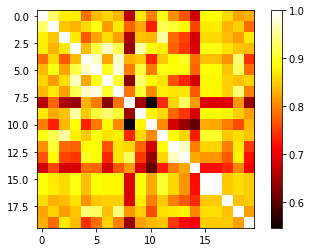

In [387]:
import matplotlib.pyplot as plt
plt.imshow(transposed_sims[0:20, 0:20], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [24]:
(transposed_sims[0] > .90).sum()

151

In [25]:
docs = transposed_sims


In [27]:
embedding.shape

(2525, 768)

In [28]:
from sklearn.cluster import AgglomerativeClustering as AC

In [29]:
cm = AC(n_clusters = 500, affinity = 'precomputed', linkage='average')

In [30]:
cm.fit(1 - transposed_sims)

AgglomerativeClustering(affinity='precomputed', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=500)

In [391]:
names['cluster'] = cm.labels_
names.cluster.value_counts()

In [40]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

In [303]:
def test_reduced_dims(df_fixed, response, dists, n_dims, names):
    """
    reduces the dimensions by aggregating based on cluster similarity
    """
    cm = AC(n_clusters = n_dims, affinity = 'precomputed', linkage='average')
    cm.fit(1 - dists)
    names['cluster'] = cm.labels_
    reduced = df_fixed.copy()
    reduced.columns = names.cluster
    reduced = reduced.transpose().groupby('cluster').sum().transpose()
    reduced_resp = reduced.merge(response[['#SampleID', 'Var']], \
                 how = 'inner', 
                 left_index = True, right_on = '#SampleID').drop('#SampleID', axis = 1)

    X = reduced_resp.drop('Var', axis = 1)
    #taking the less common class as the positive response
    y = reduced_resp.Var == pd.DataFrame( response.Var.value_counts() ).index[1]
    
    #doing K-Fold cross validation, to get 100+ predictions
    
#     X_train, X_test, y_train, y_test = train_test_split(\
#                         X, y, test_size=0.15, random_state=42)
    PREDS = []
    TRUES = []
    
    kf = KFold(n_splits=5, random_state=None, shuffle=True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]

        rf = RandomForestClassifier(n_estimators = 100)
        rf.fit(X_train, y_train)
        clustered_rf_preds = rf.predict_proba(X_test)

        PREDS.append( clustered_rf_preds[:, 1] )
        TRUES.append( y_test )
        
    
    all_preds = np.concatenate(PREDS)
    all_trues = np.concatenate(TRUES)
        
    fpr, tpr, thresholds = roc_curve(all_trues, all_preds)

    auc_val = auc(fpr, tpr)
        
    return(fpr, tpr, auc_val, n_dims)

In [44]:
L = []
for i in [df_fixed.shape[1], 2000, 1500, 1000, 500]:
    L.append( test_reduced_dims(df_fixed, response, transposed_sims, i, names) )

[0.5  0.32 0.34 0.46 0.54 0.49 0.41 0.3  0.61 0.28 0.67 0.6  0.48 0.51
 0.36 0.51 0.65 0.6  0.7  0.52 0.64 0.34 0.58 0.56 0.56]
11     False
13     False
23     False
25     False
27     False
29     False
34     False
45     False
47     False
48     False
64     False
71     False
72     False
75      True
84      True
91      True
92      True
100     True
102     True
104     True
110     True
118     True
120     True
121     True
122     True
Name: Var, dtype: bool
[0.45 0.55 0.52 0.56 0.58 0.41 0.53 0.42 0.38 0.4  0.46 0.46 0.39 0.6
 0.64 0.44 0.42 0.54 0.58 0.55 0.59 0.5  0.51 0.48 0.65]
0       True
2      False
4      False
5      False
8      False
10     False
17     False
21     False
24     False
26     False
40     False
49     False
51     False
58     False
60      True
61     False
62     False
65     False
80      True
93      True
94      True
95      True
96      True
112     True
114     True
Name: Var, dtype: bool
[0.7  0.35 0.55 0.44 0.46 0.39 0.49 0.51 0.43 0.3

[0.49 0.4  0.43 0.46 0.42 0.48 0.54 0.45 0.31 0.3  0.55 0.48 0.47 0.52
 0.42 0.63 0.5  0.55 0.51 0.57 0.68 0.64 0.5  0.47]
5      False
18     False
24     False
26     False
33     False
39     False
42     False
45     False
48     False
50     False
55      True
56     False
66      True
68     False
70     False
76      True
80      True
85      True
99      True
100     True
102     True
105     True
106     True
109     True
Name: Var, dtype: bool
[0.63 0.4  0.57 0.55 0.39 0.49 0.61 0.54 0.45 0.35 0.48 0.49 0.78 0.4
 0.53 0.45 0.36 0.53 0.59 0.46 0.71 0.75 0.46 0.67 0.57]
2      False
3      False
4      False
5      False
10     False
12     False
16     False
18     False
24     False
27     False
34     False
41     False
42     False
48     False
49     False
59     False
61     False
63      True
86      True
88      True
92      True
102     True
103     True
105     True
106     True
Name: Var, dtype: bool
[0.48 0.39 0.59 0.49 0.53 0.5  0.3  0.5  0.26 0.31 0.49 0.44 0.27 0

In [45]:
full_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_dims':[a[3]]*len(a[1]) } ) \
           for a in L ], axis = 0 )

full_results['Grouping Dimension'] = full_results.n_dims.astype(str) + ', AUC = ' \
                        + full_results.auc.astype(str).str[0:4]

In [46]:
full_results.head() 

,fpr,tpr,auc,n_dims,Grouping Dimension
0,0.000000,0.000000,0.666362,2525,"2525, AUC = 0.66"
1,0.015385,0.016949,0.666362,2525,"2525, AUC = 0.66"
2,0.030769,0.033898,0.666362,2525,"2525, AUC = 0.66"
3,0.030769,0.118644,0.666362,2525,"2525, AUC = 0.66"
4,0.046154,0.169492,0.666362,2525,"2525, AUC = 0.66"


In [402]:
names

,id,emb_idx
0,Bacteria; Bacteroidetes; Bacteroidia; Bactero...,0
1,Bacteria; Actinobacteria; Coriobacteriia; Cor...,1
2,Bacteria; Actinobacteria; Actinobacteria; Bif...,2
3,Bacteria; Actinobacteria; Actinobacteria; Bif...,3
4,Bacteria; Actinobacteria; Actinobacteria; Act...,4
...,...,...
441,Bacteria; Tenericutes; Mollicutes; Mycoplasma...,441
442,Bacteria; Tenericutes; RF3; ML615J-28,442
443,Bacteria; Verrucomicrobia; Opitutae; Opitutal...,443
444,Bacteria; WPS-2,444


In [407]:
reduced = df_fixed.copy()
names['cluster'] = cm.labels_
reduced.columns = names.cluster
reduced = reduced.transpose().groupby('cluster').sum().transpose()

reduced.head()

cluster,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
NLF008,0.000000e+00,0.000000e+00,0.001186,0.0,0.020619,0.000655,0.0,0.107423,0.000047,0.006941,...,0.005184,0.000004,0.000000e+00,0.0,0.0,0.0,2.145386e-07,0.00000,0.000062,0.0
DLM017,5.335119e-07,0.000000e+00,0.000166,0.0,0.046542,0.000064,0.0,0.025006,0.000044,0.003259,...,0.004574,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.00000,0.000054,0.0
DLM015,2.303959e-07,0.000000e+00,0.000287,0.0,0.063039,0.000425,0.0,0.014658,0.000033,0.005326,...,0.004029,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.00000,0.000047,0.0
DOF004,3.601148e-07,0.000000e+00,0.001067,0.0,0.052356,0.002594,0.0,0.000330,0.000046,0.002334,...,0.003132,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.00032,0.000054,0.0
DOF003,0.000000e+00,2.221492e-07,0.014017,0.0,0.058937,0.000005,0.0,0.000240,0.000060,0.009348,...,0.005406,0.000000,2.221492e-07,0.0,0.0,0.0,1.066316e-05,0.00000,0.000052,0.0


In [399]:
cm.labels_.shape

(2525,)

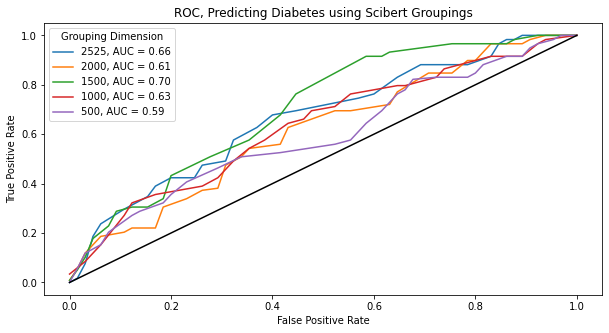

In [47]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.lineplot('fpr', 'tpr', 
             data = full_results,\
             ci= 0, hue = 'Grouping Dimension') 
plt.plot([0, 1], [0, 1], '-', color = 'black')
plt.title('ROC, Predicting Diabetes using Scibert Groupings')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## Exploring groupings based on phylogenetic names

In [319]:
num_names = 18

def test_reduce_by_phylo_name(df_fixed, response, n_cutoffs, names):
    cluster = names.id.str.split(' ').str[:n_cutoffs].str.join(' ')


    reduced = df_fixed.copy()
    reduced.columns = cluster
    reduced = reduced.transpose().groupby('id').sum().transpose()
    reduced_resp = reduced.merge(response[['#SampleID', 'Var']], \
                 how = 'inner', 
                 left_index = True, right_on = '#SampleID').drop('#SampleID', axis = 1)

    X = reduced_resp.drop('Var', axis = 1)
    print(n_cutoffs, X.shape)
    #taking the less common class as the positive response
    y = reduced_resp.Var == pd.DataFrame( response.Var.value_counts() ).index[1]

    #doing K-Fold cross validation, to get 100+ predictions

    #     X_train, X_test, y_train, y_test = train_test_split(\
    #                         X, y, test_size=0.15, random_state=42)
    
    PREDS = []
    TRUES = []
    
    kf = KFold(n_splits=5, random_state=0, shuffle=True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]

        rf = RandomForestClassifier(n_estimators = 100)
        rf.fit(X_train, y_train)
        clustered_rf_preds = rf.predict_proba(X_test)

        PREDS.append( clustered_rf_preds[:, 1] )
        TRUES.append( y_test )

    all_preds = np.concatenate(PREDS)
    all_trues = np.concatenate(TRUES)

    fpr, tpr, thresholds = roc_curve(all_trues, all_preds)

    auc_val = auc(fpr, tpr)

    return(fpr, tpr, auc_val, X.shape[1] )

In [69]:
G = []
for i in [1, 2, 3, 5, 7]:
    G.append( test_reduce_by_phylo_name(df_fixed, response, i, names) )

1 (124, 1889)
2 (124, 1772)
3 (124, 1470)
5 (124, 732)
7 (124, 209)


In [409]:
phylo_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_cutoffs':[a[3]]*len(a[1]) } ) \
           for a in G ], axis = 0 )

phylo_results['Phylo Tree Depth'] = phylo_results.n_cutoffs.astype(str) + ', AUC = ' \
                        + phylo_results.auc.astype(str).str[0:4]

In [422]:
names.loc[names.cluster == 72].id.values

array([' Bacteria Actinobacteria Actinobacteria Micrococcales Microbacteriaceae Agrococcus Agrococcu lahaulensis Agrococcu lahaulensi DSM_17612',
       ' Bacteria Firmicutes Bacilli Bacillales Staphylococcaceae Macrococcus Macrococcu caseolyticus Macrococcu caseolyticu JCSC5402',
       ' Bacteria Firmicutes Bacilli Bacillales Staphylococcaceae Jeotgalicoccus Jeotgalicoccu marinus Jeotgalicoccu marinu DSM_19772',
       ' Bacteria Firmicutes Bacilli Lactobacillales Aerococcaceae Eremococcus Eremococcu coleocola Eremococcu coleocol DSM_15696',
       ' Bacteria Firmicutes Bacilli Lactobacillales Carnobacteriaceae Atopococcus Atopococcu tabaci Atopococcu tabac DSM_17538',
       ' Bacteria Firmicutes Bacilli Lactobacillales Carnobacteriaceae Alloiococcus Alloiococcu otitis Alloiococcu otiti ATCC_51267',
       ' Bacteria Firmicutes Bacilli Lactobacillales Leuconostocaceae Oenococcus Oenococcu oeni Oenococcu oen PSU-1',
       ' Bacteria Firmicutes Bacilli Lactobacillales Leuconostocacea

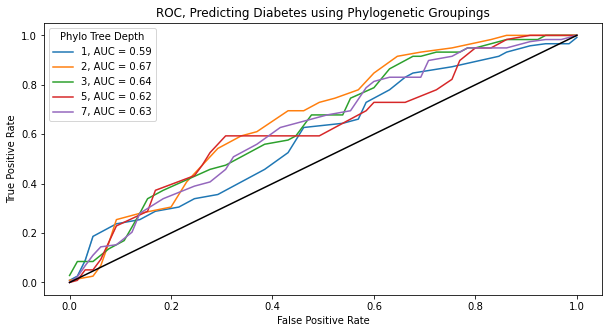

In [411]:

plt.figure(figsize=(10,5))
sns.lineplot('fpr', 'tpr', 
             data = phylo_results,\
             ci= 0, hue = 'Phylo Tree Depth') 
plt.plot([0, 1], [0, 1], '-', color = 'black')
plt.title('ROC, Predicting Diabetes using Phylogenetic Groupings')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

In [85]:
scaled = StandardScaler().fit_transform(df_fixed)
pc = PCA(n_components = 100)
reduced = pc.fit_transform(scaled)


array([[-2.61802138, -2.98089259, -1.5720185 , ..., -4.09726916,
         1.37002037,  0.69196272],
       [-2.2766929 , -2.60761639, -2.15877535, ..., -3.39799767,
         1.37885249, -3.42396055],
       [-1.86673858, -1.30772672, -2.29062015, ...,  1.94525864,
         0.35637839, -1.3791513 ],
       ...,
       [-2.91216411, -3.50176408, -2.41760405, ..., -0.21056981,
        -0.82195202, -2.08631925],
       [-2.98384097, -3.87786921, -2.67964887, ...,  0.26696077,
        -0.97503716, -1.36868243],
       [-2.70762125, -3.83618349, -2.5032746 , ..., -1.04896224,
        -1.36891656, -2.06100334]])

In [108]:

def test_reduce_by_PCA(df_fixed, response, reduce_dim):
    
    merge_resps = df_fixed.merge(response[['#SampleID', 'Var']], \
                 how = 'inner', 
                 left_index = True, right_on = '#SampleID').drop('#SampleID', axis = 1)
    
    scaled = StandardScaler().fit_transform(merge_resps.drop('Var', axis = 1))
    pc = PCA(n_components = reduce_dim)
    X = pc.fit_transform(scaled)

    #taking the less common class as the positive response
    y = merge_resps.Var == pd.DataFrame( response.Var.value_counts() ).index[1]

    #doing K-Fold cross validation, to get 100+ predictions

    #     X_train, X_test, y_train, y_test = train_test_split(\
    #                         X, y, test_size=0.15, random_state=42)
    
    PREDS = []
    TRUES = []
    
    kf = KFold(n_splits=5, random_state=0, shuffle=True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index,:], X[test_index,:]
        y_train, y_test = y[train_index], y[test_index]

        rf = RandomForestClassifier(n_estimators = 100)
        rf.fit(X_train, y_train)
        clustered_rf_preds = rf.predict_proba(X_test)

        PREDS.append( clustered_rf_preds[:, 1] )
        TRUES.append( y_test )

    all_preds = np.concatenate(PREDS)
    all_trues = np.concatenate(TRUES)

    fpr, tpr, thresholds = roc_curve(all_trues, all_preds)

    auc_val = auc(fpr, tpr)

    return(fpr, tpr, auc_val, reduce_dim)

In [109]:
%time

H = []

for i in [10, 50, 100]:
    print(i)
    H.append( test_reduce_by_PCA(df_fixed, response, i) )
    


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 17.9 µs
10
50
100


In [110]:
PCA_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'dim':[a[3]]*len(a[1]) } ) \
           for a in H ], axis = 0 )

PCA_results['Dimension'] = PCA_results.dim.astype(str) + ', AUC = ' \
                        + PCA_results.auc.astype(str).str[0:4]

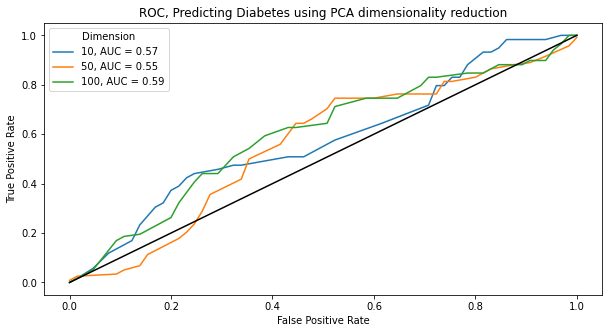

In [113]:

plt.figure(figsize=(10,5))
sns.lineplot('fpr', 'tpr', 
             data = PCA_results,\
             ci= 0, hue = 'Dimension') 
plt.plot([0, 1], [0, 1], '-', color = 'black')
plt.title('ROC, Predicting Diabetes using PCA dimensionality reduction')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Wrapping the tests of one dataset into a single function, taking the path to the folder as an input

Download single file with all the training tasks from: https://knights-lab.github.io/MLRepo/

In [129]:
import os
from os import listdir
import glob

dirs = listdir('knights_datasets')

dirs = ['knights_datasets/' + a for a in dirs if a[0] != '.']

In [135]:
dir_path = dirs[5]
dir_path

'knights_datasets/qin2012'

In [137]:
for file in os.listdir(dir_path):# + '/gg'):
        print(file)

task-healthy-diabetes.txt
otutable.txt
taxatable.txt
mapping-orig.txt


In [155]:
len(dirs)

17

In [163]:

pd.api.types.is_numeric_dtype(response.Var)

False

In [ ]:
#

In [181]:
dir_path

'knights_datasets/bushman_cafe'

In [186]:
df

,#OTU ID,100052.1246453,MGH103687.1246642,121279.1246886,100101.1247239,121400.1246372,SKBTI.1289.1247274,121285.1246733,100188.1247093,120155.1246996,...,SKBTI006.1247355,SKBTI.0767.1246917,MGH106271.1246160,SKBTI.0652.1246739,SKBTI.0593.1247128,SKBTI.0914.1246971,SKBTI.0448.1246164,SKBTI.0939.1246784,SKBTI.0692.1246233,SKBTI.0362.1246358
0,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,280,208,475,19,131,3,772,1843,286,...,0,0,0,0,0,0,0,0,0,0
1,k__Bacteria; p__Actinobacteria; c__Coriobacter...,148,0,16,61,118,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,k__Bacteria; p__Actinobacteria; c__Actinobacte...,7,3,0,0,46,0,4,3,25,...,0,0,0,0,0,0,0,0,0,0
3,k__Bacteria; p__Actinobacteria; c__Actinobacte...,12,1,0,45,521,2,46,1,200,...,0,0,0,0,0,0,0,0,0,0
4,k__Bacteria; p__Actinobacteria; c__Actinobacte...,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441,k__Bacteria; p__Tenericutes; c__Mollicutes; o_...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
442,k__Bacteria; p__Tenericutes; c__RF3; o__ML615J-28,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
443,k__Bacteria; p__Verrucomicrobia; c__Opitutae; ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
444,k__Bacteria; p__WPS-2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [191]:
all_names = []
j = 0
for dir_path in dirs:
    i = 0 
    for file in os.listdir(dir_path):

        if file.startswith("task"):
            if i == 0:
                response = pd.read_csv(dir_path + '/' + file, sep = '\t')
                i += 1
                
            if i > 0 and pd.api.types.is_numeric_dtype(response.Var) == True:
                response = pd.read_csv(dir_path + '/' + file, sep = '\t')
                i += 1
            
    try:
        df = pd.read_csv(dir_path + '/taxatable.txt', sep = '\t')
    except:
        df = pd.read_csv(dir_path + '/gg/taxatable.txt', sep = '\t')
           
         
    print(dir_path)
    if i > 0:
        df['id'] = df[df.columns[0]].str.replace(r';*[a-z]_+', ' ').str.replace(r' +', ' ')
        df_fixed = fix_df(df)
        print(df_fixed.iloc[1:5, 1])
        names = pd.DataFrame( df_fixed.columns.dropna() )
        names['emb_idx'] = names.index
        
        all_names.append(names)

        

knights_datasets/gevers
MGH103687.1246642             0
121279.1246886       0.00242866
100101.1247239       0.00728619
121400.1246372         0.014899
Name:  Bacteria; Actinobacteria; Coriobacteriia; Coriobacteriales; Coriobacteriaceae; Collinsella; aerofaciens, dtype: object
knights_datasets/claesson
EM056.T3.441716      0.532186
EM034.441676         0.135696
EM056.441606         0.379472
EM059.T3.441604    0.00106797
Name:  Bacteria; Bacteroidetes; Bacteroidia; Bacteroidales, dtype: object
knights_datasets/cho
SRR521196     0.0156546
SRR521173    0.00549915
SRR521188    0.00766983
SRR521253     0.0128496
Name:  Bacteria; Bacteroidetes; Bacteroidia; Bacteroidales; Bacteroidaceae; Bacteroides; acidifaciens, dtype: object
knights_datasets/ravel
SRR062725    0
SRR062843    0
SRR063047    0
SRR062731    0
Name:  Bacteria; Actinobacteria; Actinobacteria; Actinomycetales; Propionibacteriaceae; Propionibacterium; acnes, dtype: object
knights_datasets/qin2014
LD.11      0.0103151
LD.26     0

In [204]:
ALL_NAMES = pd.concat(all_names, axis = 0)
unique_names = pd.DataFrame( sorted( ALL_NAMES.id.unique() ) )
unique_names['emb_idx'] = unique_names.index
unique_names.columns = ['id', 'emb_idx']
unique_names

,id,emb_idx
0,Archaea Crenarchaeota Thermoprotei Desulfuroc...,0
1,Archaea Euryarchaeota,1
2,Archaea Euryarchaeota Halobacteria Haloferaca...,2
3,Archaea Euryarchaeota Halobacteria Haloferaca...,3
4,Archaea Euryarchaeota Halobacteria Natrialbal...,4
...,...,...
6553,Viruses unclassifie bacteria viruses Streptoc...,6553
6554,Viruses unclassifie bacteria viruses Streptoc...,6554
6555,Viruses unclassifie bacteria viruses Streptoc...,6555
6556,Viruses unclassifie bacteria viruses Streptoc...,6556


In [216]:
embeddings = create_embeddings( unique_names.id, model, tokenizer)

In [217]:
print('COMPLETED ALL EMBEDDINGS')

COMPLETED ALL EMBEDDINGS


In [234]:
all_names[8]

,id,emb_idx
0,Bacteria; Firmicutes; Clostridia; Clostridial...,0
1,Bacteria; Firmicutes; Clostridia; Clostridiales,1
2,Bacteria; Bacteroidetes; Bacteroidia; Bactero...,2
3,Bacteria; Bacteroidetes; Bacteroidia; Bactero...,3
4,Bacteria; Actinobacteria; Coriobacteriia; Cor...,4
...,...,...
227,Bacteria; Synergistetes; Synergistia; Synergi...,227
228,Bacteria; TM7; TM7-3; I025; Rs-045,228
229,Bacteria; TM7; TM7-3,229
230,Bacteria; Tenericutes; RF3; ML615J-28,230


In [246]:
def get_dist_matrix(embeddings, names):
    specific_indexes = names.merge(unique_names, how = 'left', on = 'id').emb_idx_y
    embs = embeddings[specific_indexes]
    
    n = len(embs)

    sims = np.zeros((n, n))

    #getting cosine similarities -- theres probably a good function for this...
    for i in range(n):
        for j in range(i, n):
            sims[i,j] = embs[i].dot(embs[j])/ \
                        (np.linalg.norm(embs[i]) * np.linalg.norm(embs[j]))
    
    return( sims + sims.T - np.eye(sims.shape[0]) )

In [290]:
def extract_files(dir_path):
    i = 0 
    for file in os.listdir(dir_path):

        if file.startswith("task"):
            if i == 0:
                response = pd.read_csv(dir_path + '/' + file, sep = '\t')
                i += 1
                
            if i > 0 and pd.api.types.is_numeric_dtype(response.Var) == True:
                response = pd.read_csv(dir_path + '/' + file, sep = '\t')
                i += 1
            
    try:
        df = pd.read_csv(dir_path + '/taxatable.txt', sep = '\t')
    except:
        df = pd.read_csv(dir_path + '/gg/taxatable.txt', sep = '\t')
           
         

    if i > 0:
        df['id'] = df[df.columns[0]].str.replace(r';*[a-z]_+', ' ').str.replace(r' +', ' ')
        df_fixed = fix_df(df)
        names = pd.DataFrame( df_fixed.columns.dropna() )
        names['emb_idx'] = names.index
        
    return(df_fixed, response, names)

In [282]:
dir_path

'knights_datasets/bushman_cafe'

In [283]:
df, response, names = extract_files( 'knights_datasets/gevers' )

In [284]:
response['#SampleID']

0      SKBTI.1189.1246772
1      SKBTI.1127.1246735
2      SKBTI.1057.1247436
3      SKBTI.1235.1246803
4      SKBTI.1187.1246947
              ...        
155    SKBTI.1299.1247431
156    SKBTI.1338.1247013
157    SKBTI.1313.1246920
158    SKBTI.1346.1247074
159    SKBTI.1026.1246716
Name: #SampleID, Length: 160, dtype: object

In [289]:
df.head()

,#OTU ID,100052.1246453,MGH103687.1246642,121279.1246886,100101.1247239,121400.1246372,SKBTI.1289.1247274,121285.1246733,100188.1247093,120155.1246996,...,SKBTI.0767.1246917,MGH106271.1246160,SKBTI.0652.1246739,SKBTI.0593.1247128,SKBTI.0914.1246971,SKBTI.0448.1246164,SKBTI.0939.1246784,SKBTI.0692.1246233,SKBTI.0362.1246358,id
0,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,280,208,475,19,131,3,772,1843,286,...,0,0,0,0,0,0,0,0,0,Bacteria; Bacteroidetes; Bacteroidia; Bactero...
1,k__Bacteria; p__Actinobacteria; c__Coriobacter...,148,0,16,61,118,1,0,0,0,...,0,0,0,0,0,0,0,0,0,Bacteria; Actinobacteria; Coriobacteriia; Cor...
2,k__Bacteria; p__Actinobacteria; c__Actinobacte...,7,3,0,0,46,0,4,3,25,...,0,0,0,0,0,0,0,0,0,Bacteria; Actinobacteria; Actinobacteria; Bif...
3,k__Bacteria; p__Actinobacteria; c__Actinobacte...,12,1,0,45,521,2,46,1,200,...,0,0,0,0,0,0,0,0,0,Bacteria; Actinobacteria; Actinobacteria; Bif...
4,k__Bacteria; p__Actinobacteria; c__Actinobacte...,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Bacteria; Actinobacteria; Actinobacteria; Act...


In [288]:
df_fixed.index

Index(['100052.1246453', 'MGH103687.1246642', '121279.1246886',
       '100101.1247239', '121400.1246372', 'SKBTI.1289.1247274',
       '121285.1246733', '100188.1247093', '120155.1246996', '100211.1246832',
       ...
       'SKBTI006.1247355', 'SKBTI.0767.1246917', 'MGH106271.1246160',
       'SKBTI.0652.1246739', 'SKBTI.0593.1247128', 'SKBTI.0914.1246971',
       'SKBTI.0448.1246164', 'SKBTI.0939.1246784', 'SKBTI.0692.1246233',
       'SKBTI.0362.1246358'],
      dtype='object', length=1359)

In [253]:
dir_path

'knights_datasets/bushman_cafe'

In [291]:
df_fixed, response, names = extract_files('knights_datasets/gevers')

In [263]:
dists = get_dist_matrix(embeddings, names)

In [293]:
response

,#SampleID,Var
0,SKBTI.1189.1246772,CD
1,SKBTI.1127.1246735,no
2,SKBTI.1057.1247436,no
3,SKBTI.1235.1246803,no
4,SKBTI.1187.1246947,no
...,...,...
155,SKBTI.1299.1247431,no
156,SKBTI.1338.1247013,CD
157,SKBTI.1313.1246920,no
158,SKBTI.1346.1247074,CD


In [296]:
df_fixed.merge(response, how = 'inner', left_index = True, right_on = '#SampleID')

,Bacteria; Bacteroidetes; Bacteroidia; Bacteroidales; Bacteroidaceae; Bacteroides,Bacteria; Actinobacteria; Coriobacteriia; Coriobacteriales; Coriobacteriaceae; Collinsella; aerofaciens,Bacteria; Actinobacteria; Actinobacteria; Bifidobacteriales; Bifidobacteriaceae; Bifidobacterium; adolescentis,Bacteria; Actinobacteria; Actinobacteria; Bifidobacteriales; Bifidobacteriaceae; Bifidobacterium,Bacteria; Actinobacteria; Actinobacteria; Actinomycetales; Actinomycetaceae,Bacteria; Actinobacteria; Actinobacteria,Bacteria,Archaea; Euryarchaeota; Methanobacteria; Methanobacteriales; Methanobacteriaceae; Methanobrevibacter,Archaea; Euryarchaeota; Methanobacteria; Methanobacteriales; Methanobacteriaceae; Methanobacterium; bryantii,Archaea; Euryarchaeota; Methanobacteria; Methanobacteriales; Methanobacteriaceae; Methanobacterium,...,Bacteria; TM7; TM7-3,Bacteria; TM7; TM7-3; CW040; F16,Bacteria; TM7; TM7-3; CW040,Bacteria; Tenericutes; Mollicutes; Mycoplasmatales; Mycoplasmataceae; Mycoplasma; muris,Bacteria; Tenericutes; RF3; ML615J-28,Bacteria; Verrucomicrobia; Opitutae; Opitutales; Opitutaceae; Opitutus,Bacteria; WPS-2,Bacteria; Verrucomicrobia; Verrucomicrobiae; Verrucomicrobiales; Verrucomicrobiaceae; Prosthecobacter; debontii,#SampleID,Var
0,0.163934,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,SKBTI.1189.1246772,CD
1,0.0213904,0,0,0.0026738,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,SKBTI.1127.1246735,no
2,0.0477178,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,SKBTI.1057.1247436,no
3,0.121113,0.00490998,0,0.00327332,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,SKBTI.1235.1246803,no
4,0.10483,0,0,0.0349435,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,SKBTI.1187.1246947,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0,0,0,0.00526316,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,SKBTI.1299.1247431,no
156,0.0165441,0,0,0.00735294,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,SKBTI.1338.1247013,CD
157,0.0196078,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,SKBTI.1313.1246920,no
158,0.00151286,0,0.00151286,0.0121029,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,SKBTI.1346.1247074,CD


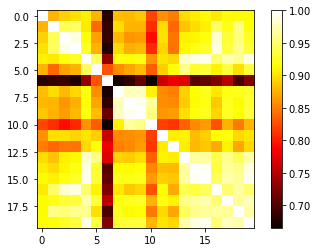

In [267]:
plt.imshow(dists[0:20, 0:20], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

In [316]:
response.Var.unique()[1]

'no'

In [325]:
def run_tests(dir_path, embeddings):
    """
    given a file path:
    
    1. extract counts matrix / prediction tasks from path
    2. get similarity matrix of the different samples in the count matrices
    3. get roc/auc of rf prediction task by clustering based on bert encoding similarities
    4. get roc/auc of rf by clustering based on phylogenetic name
    5. get roc/auc of rf by running PCA
    6. save the resulting plots
    """
    print('Extracting data, mapping embeddings')
    df_fixed, response, names = extract_files( dir_path )
    dists = get_dist_matrix(embeddings, names)
    
    
    print('Running Random Forest K folds on BERT Embeddings')
    L = []
    for i in [ df_fixed.shape[1], 
               int( .8 * df_fixed.shape[1] ),
               int( .6 * df_fixed.shape[1] ),
               int( .4 * df_fixed.shape[1] ),
               int( .2 * df_fixed.shape[1] ) ]:
        if i > 4:
            L.append( test_reduced_dims(df_fixed, response, dists, i, names) )
    
    full_results = pd.concat([ pd.DataFrame.from_dict( 
    {'fpr':a[0], 
     'tpr':a[1], 
     'auc':[a[2]]*len(a[1]),
     'n_dims':[a[3]]*len(a[1]) } ) \
           for a in L ], axis = 0 )

    full_results['Grouping Dimension'] = full_results.n_dims.astype(str) + ', AUC = ' \
                            + full_results.auc.astype(str).str[0:4]
    
    plt.figure(figsize=(10,5))
    sns.lineplot('fpr', 'tpr', 
                 data = full_results,\
                 ci= 0, hue = 'Grouping Dimension') 
    plt.plot([0, 1], [0, 1], '-', color = 'black')
    plt.title('ROC, Predicting '+ response.Var.unique()[0] + ' using Scibert Groupings')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.savefig( 'results/' + dir_path + '/scibert_groupings.png')
    
    
    
    G = []
    for i in [1, 2, 3, 4, 6, 18][::-1]:
        G.append( test_reduce_by_phylo_name(df_fixed, response, i, names) )
        
    phylo_results = pd.concat([ pd.DataFrame.from_dict( 
        {'fpr':a[0], 
         'tpr':a[1], 
         'auc':[a[2]]*len(a[1]),
         'n_cutoffs':[a[3]]*len(a[1]) } ) \
               for a in G ], axis = 0 )

    phylo_results['Amount Trimmed'] = phylo_results.n_cutoffs.astype(str) + ', AUC = ' \
                            + phylo_results.auc.astype(str).str[0:4]
    
    plt.figure(figsize=(10,5))
    sns.lineplot('fpr', 'tpr', 
                 data = phylo_results,\
                 ci= 0, hue = 'Amount Trimmed') 
    plt.plot([0, 1], [0, 1], '-', color = 'black')
    plt.title('ROC, Predicting '+ response.Var.unique()[0] + ' using Phylogenetic Groupings')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.savefig( 'results/' + dir_path + '/phylo_groupings.png')

Extracting data, mapping embeddings
Running Random Forest K folds on BERT Embeddings
1 (160, 1)
2 (160, 3)
3 (160, 23)
4 (160, 47)
6 (160, 191)
18 (160, 446)


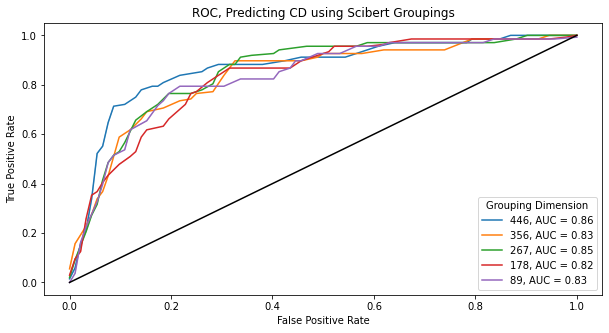

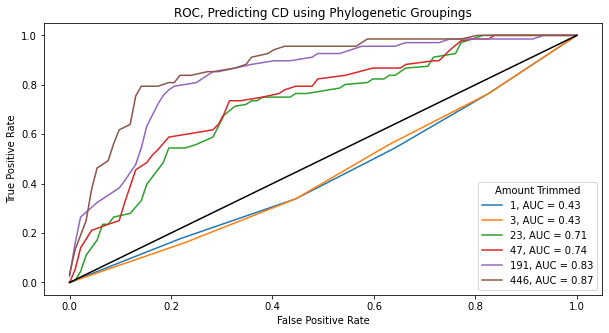

In [326]:
run_tests('knights_datasets/gevers', embeddings)

Extracting data, mapping embeddings
Running Random Forest K folds on BERT Embeddings


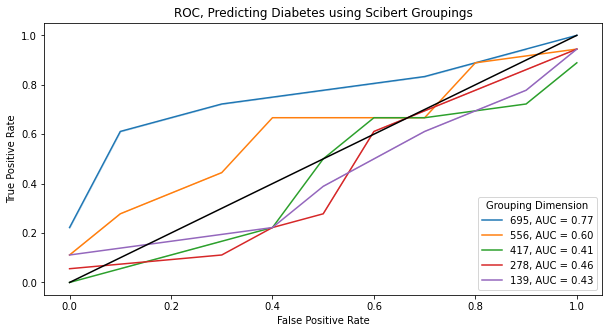

In [306]:
run_tests('knights_datasets/david', embeddings)

In [307]:
dirs

['knights_datasets/gevers',
 'knights_datasets/claesson',
 'knights_datasets/cho',
 'knights_datasets/ravel',
 'knights_datasets/qin2014',
 'knights_datasets/qin2012',
 'knights_datasets/kostic',
 'knights_datasets/karlsson',
 'knights_datasets/turnbaugh',
 'knights_datasets/ridaura',
 'knights_datasets/bacteremia',
 'knights_datasets/dethlefsen',
 'knights_datasets/yatsunenko',
 'knights_datasets/david',
 'knights_datasets/sokol',
 'knights_datasets/hmp',
 'knights_datasets/bushman_cafe']

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs
knights_datasets/gevers
Extracting data, mapping embeddings
Running Random Forest K folds on BERT Embeddings
1 (160, 1)
2 (160, 3)
3 (160, 23)
4 (160, 47)
6 (160, 191)
18 (160, 446)
knights_datasets/claesson
Extracting data, mapping embeddings
Running Random Forest K folds on BERT Embeddings
1 (167, 1)
2 (167, 2)
3 (167, 16)
4 (167, 34)
6 (167, 122)
18 (167, 279)
knights_datasets/cho
Extracting data, mapping embeddings
Running Random Forest K folds on BERT Embeddings
1 (19, 1)
2 (19, 2)
3 (19, 17)
4 (19, 32)
6 (19, 97)
18 (19, 141)
knights_datasets/ravel
Extracting data, mapping embeddings
Running Random Forest K folds on BERT Embeddings
1 (342, 1)
2 (342, 1)
3 (342, 12)
4 (342, 34)
6 (342, 141)
18 (342, 305)
knights_datasets/qin2014
Extracting data, mapping embeddings
Running Random Forest K folds on BERT Embeddings
1 (130, 1)
2 (130, 3)
3 (130, 29)
4 (130, 64)
6 (130, 337)
18 (130, 2578)
knights_datasets/qin2012
Extra

ValueError: You are trying to merge on object and float64 columns. If you wish to proceed you should use pd.concat

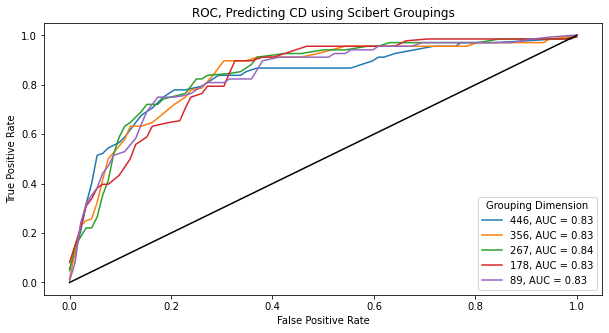

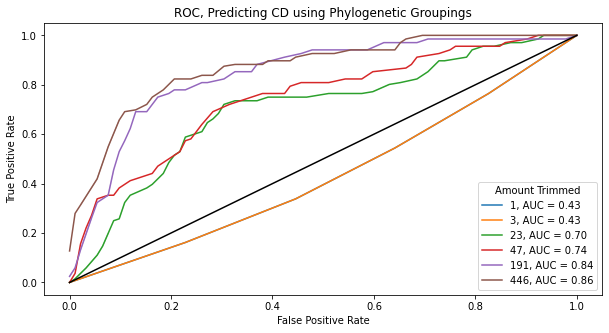

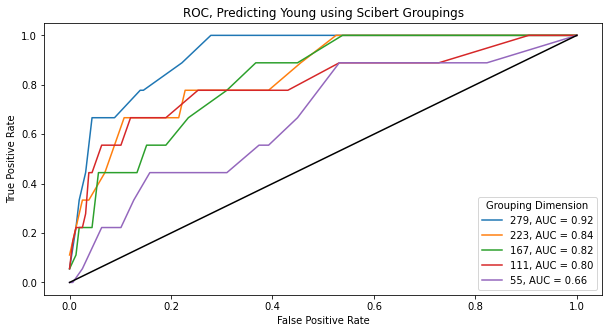

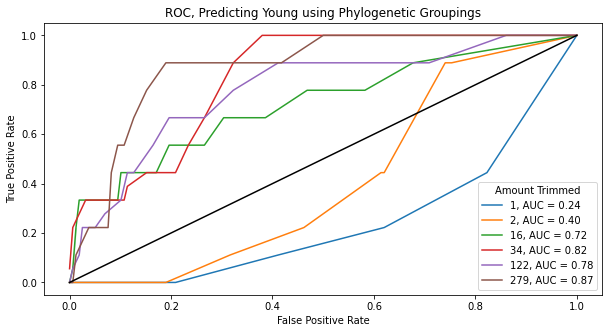

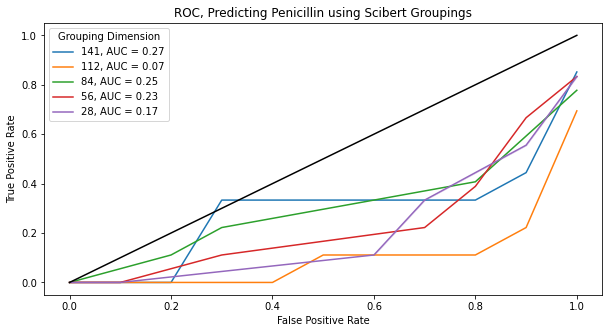

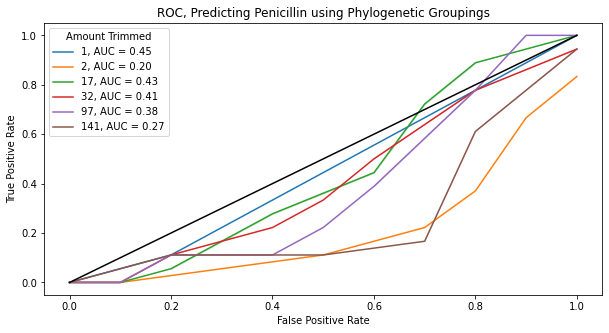

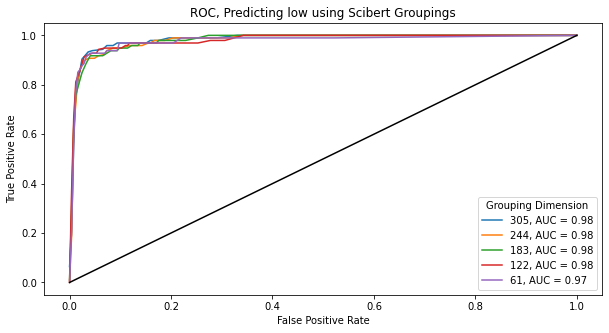

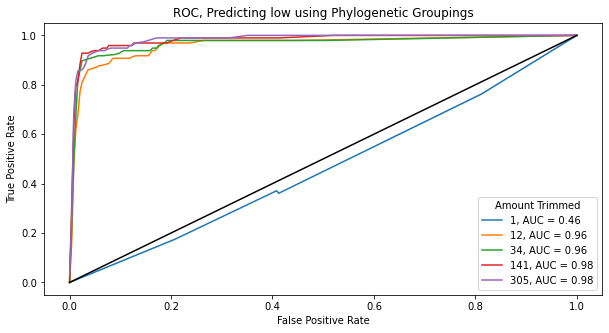

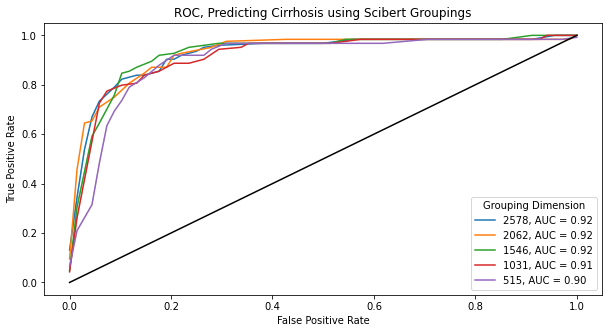

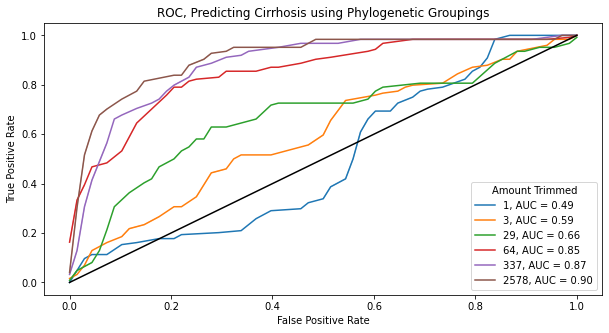

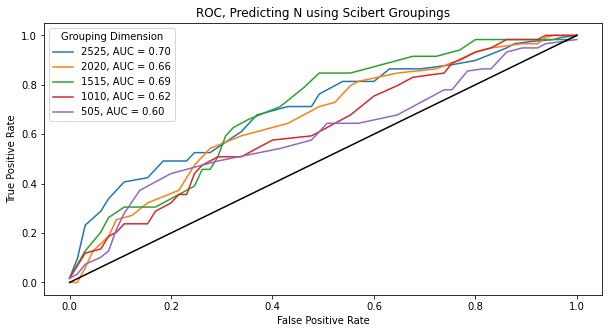

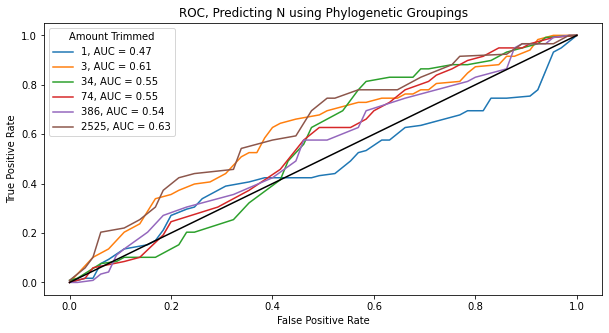

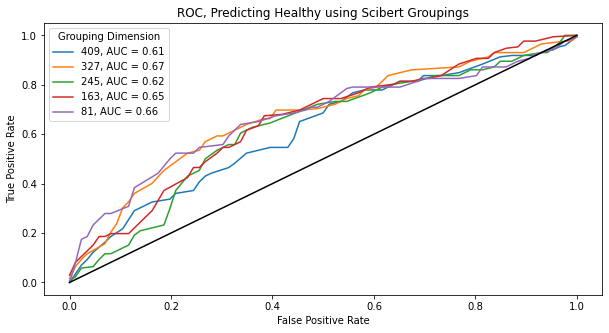

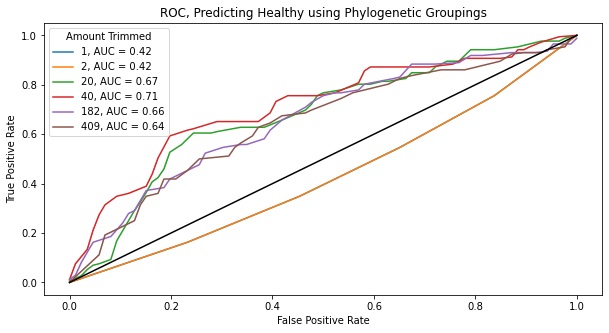

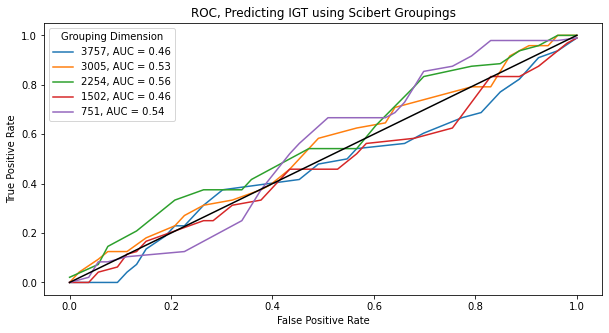

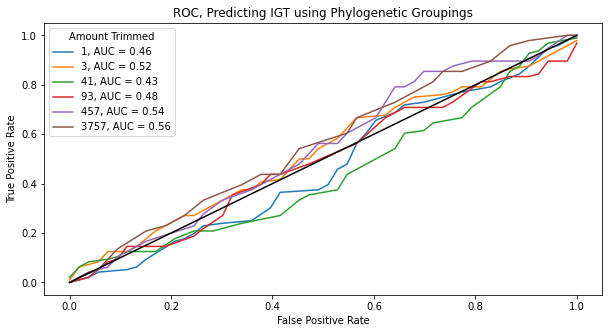

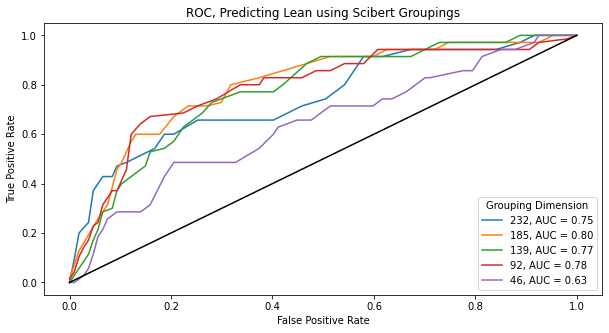

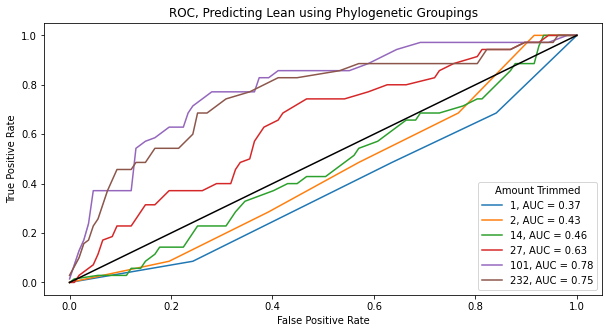

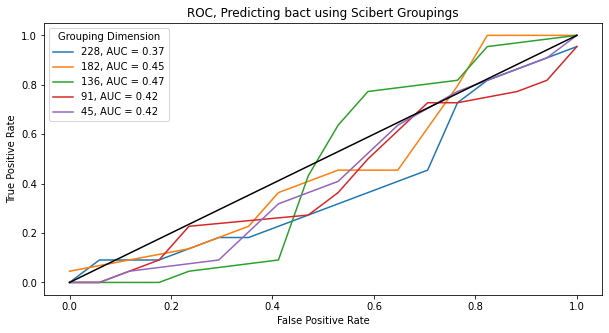

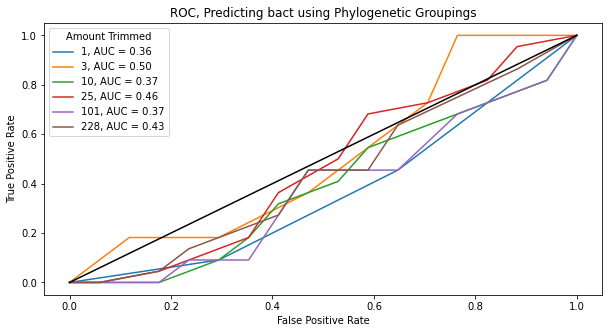

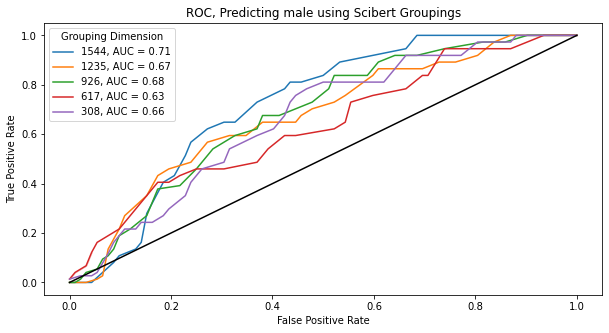

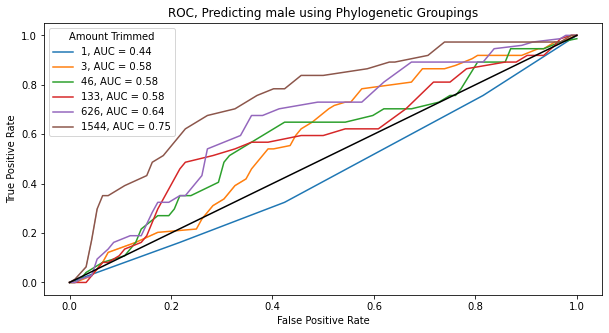

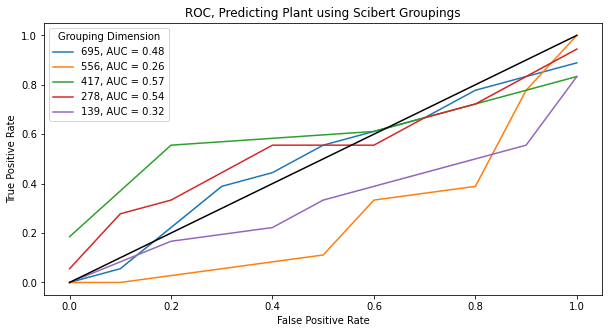

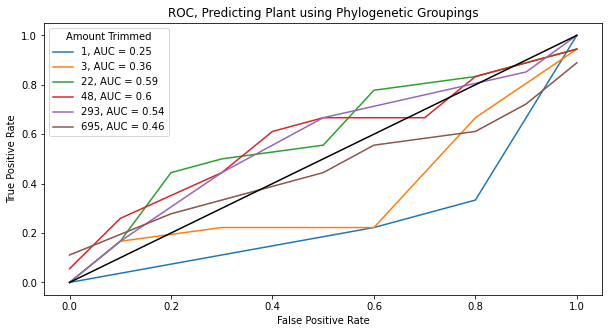

In [327]:
%time

no_tasks = ['knights_datasets/dethlefsen', 'knights_datasets/ridaura']

for dir_path in dirs:
    if dir_path not in no_tasks:
        print(dir_path)
        run_tests(dir_path, embeddings)

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
#to be clear --> this is NOT a good way to use the embeddings
A = ( Q[Q.columns[common_cols]].values @ \
                     embedding[common_cols[Q.columns.isna() == False]] )



pc = PCA(n_components = 25)
x = pc.fit_transform( StandardScaler().fit_transform(A) )
ts = TSNE(perplexity = 10)
xx = ts.fit_transform(x)

plt.scatter(xx[:, 0], xx[:, 1], c = np.array(resp == 'Y' ))
plt.show()

In [174]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

In [331]:
sentences[0:4]

0     Bacteria Bacteroidetes Bacteroidia Bacteroida...
1     Bacteria Bacteroidetes Bacteroidia Bacteroidales
2     Bacteria Actinobacteria Actinobacteria Bifido...
3     Archaea Euryarchaeota Methanobacteria Methano...
Name: id, dtype: object